In [ ]:
# Carregando as bibliotecas que serão empregadas nas análises
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import seaborn as sns
from random import randint
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
pd.options.mode.chained_assignment = None  # default='warn'

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Carregando as bases de dados que serão empregadas nas análises
data = pd.read_csv("https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/global-data-on-sustainable-energy.csv")

global_data = data.copy()                                                                                                                                                     # pd.read_csv('/content/drive/MyDrive/global-data-on-sustainable-energy.csv')
share_electricity_renewables = pd.read_csv('https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/renewable_energy/04%20share-electricity-renewables.csv')     # '/content/drive/MyDrive/04 share-electricity-renewables.csv')
countries_by_continents = pd.read_csv("https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/Countries%20by%20continents.csv")
hydro_energy_participation_per_country = pd.read_csv('https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/renewable_energy/07%20share-electricity-hydro.csv')#'/content/drive/MyDrive/07 share-electricity-hydro.csv')
wind_energy_participation_per_country =pd.read_csv('https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/renewable_energy/11%20share-electricity-wind.csv')   # '/content/drive/MyDrive/11 share-electricity-wind.csv')
solar_energy_participation_per_country = pd.read_csv('https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/renewable_energy/15%20share-electricity-solar.csv')# '/content/drive/MyDrive/15 share-electricity-solar.csv')
biofuel_production_per_country = pd.read_csv('https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/renewable_energy/16%20biofuel-production.csv')             # '/content/drive/MyDrive/16 biofuel-production.csv')

#Série histórica da participação média de fontes de energia renováveis na matriz energética mundial, entre os anos de 2000 e 2021:

In [ ]:
# Preparando o Dataframe e adicinando o continente de cada país na tabela
share_electricity_renewables = share_electricity_renewables.drop(columns=['Code'])
share_electricity_renewables = share_electricity_renewables.rename(columns={'Entity': 'Country'})
share_electricity_renewables = share_electricity_renewables.merge(countries_by_continents)

# Removendo linhas com dados ausentes (aqui considerados como 0)
share_electricity_renewables = share_electricity_renewables[share_electricity_renewables['Renewables (% electricity)'] != 0]

# Removendo nos quais os dados de alguns locais são escassos e podem prejudicar a análise da média
share_electricity_renewables = share_electricity_renewables.query('Year >= 2000 and Year <= 2021')

Podemos primeiramente buscar observar como os países vêm adotando fontes de energia renováveis nas últimas décadas, segmentando primeiramente pela localização de cada país:

In [ ]:
# Agrupando os dados por continente e por ano, mantendo a média da participação de fontes renováveis no total mundial
average_share_electricity_renewables_per_continent = (share_electricity_renewables
                                                      .groupby(['Continent', 'Year'])
                                                      ['Renewables (% electricity)']
                                                      .mean()
                                                      .round(2)
                                                      .reset_index())

# Plotando gráfico de linhas com a série histórica obtida para cada continente
average_share_electricity_renewables_per_continent_plot = px.line(average_share_electricity_renewables_per_continent,
                                                                  x='Year',
                                                                  y='Renewables (% electricity)',
                                                                  color = 'Continent',
                                                                  color_discrete_sequence=px.colors.qualitative.T10,
                                                                  labels={"Continent": "Continente"},
                                                                  width=700,
                                                                  height=700)

# Atualizando títulos e cores no gráfico
average_share_electricity_renewables_per_continent_plot.update_layout(title_text='<b>Evolução da participação de fontes renováveis<br>na matriz energética de cada continente (2000 - 2021)<b>',
                                                                      title_x=0.5,
                                                                      font_size=12,
                                                                      xaxis_title='Ano',
                                                                      yaxis_title='Porcentagem (%)')

average_share_electricity_renewables_per_continent_plot.show()

Nota-se uma queda na participação das fontes limpas nas matrizes energéticas de grande parte dos continentes, com exceção da Europa, que apresentou um crescimento considerável a partir do ano de 2008.

Podemos remover a divisão por continentes e buscar observar qual a evolução da média global no mesmo intervalo:

In [ ]:
# Agrupando os dados por ano, mantendo a média da participação de fontes renováveis no total mundial
average_share_electricity_renewables_per_year = (share_electricity_renewables
                                                 .groupby('Year')
                                                 ['Renewables (% electricity)']
                                                 .mean()
                                                 .round(2)
                                                 .reset_index())

# Plotando gráfico de linhas com a série histórica obtida
average_share_electricity_renewables_per_year_plot = px.line(average_share_electricity_renewables_per_year,
                                                             x='Year',
                                                             y='Renewables (% electricity)',
                                                             width=700,
                                                             height=700)

# Atualizando títulos e cores no gráfico
average_share_electricity_renewables_per_year_plot.update_layout(title_text='<b>Evolução da participação de fontes renováveis<br>na matriz energética mundial (2000 - 2021)<b>',
                                                                 title_x=0.5,
                                                                 font_size=12,
                                                                 xaxis_title='Ano',
                                                                 yaxis_title='Porcentagem (%)')

average_share_electricity_renewables_per_year_plot.update_traces(line_color='mediumseagreen')

average_share_electricity_renewables_per_year_plot.show()

A partir das tandências reveladas anteriormente, é de se esperar que a tendência mundial média no emprego de fontes de energia renováveis apresente uma queda nas duas primeiras décadas do século XXI. Tal cenário é preocupante, já que indica uma tendência geral de não investimento em fontes limpas e mais foco em recursos poluentes.

#Taxa da energia consumida em cada localidade que provém de fontes verdes de energia:

In [ ]:
# Preparando o Dataframe e adicionando uma coluna de continentes na tabela
global_data.rename(columns={'Entity': 'Country'}, inplace=True)

global_data = pd.merge(global_data, countries_by_continents)

# Transformando a coluna de ajuda financeira de dólares para bilhões de dólares
global_data['Financial flows to developing countries (US $)'] = global_data['Financial flows to developing countries (US $)'].div(1e9)

Aqui, iremos fazer uma análise do quanto da energia consumida em cada localidade advém de fontes de energia não fósseis. Tal dado é relevante pois é possível que uma região produza uma quantidade relevante de energia limpa, mas que o mesmo montante não seja efetivamente consumido pela população do próprio país.

In [ ]:
# Preparando as colunas de interesse
renewable_energy_in_final_consumption = global_data[['Country', 'Year', 'Renewable energy share in the total final energy consumption (%)', 'Continent']]
renewable_energy_in_final_consumption = renewable_energy_in_final_consumption.dropna()

# Agrupando os dados por continente, mantendo a média da participação de fontes renováveis no consumo final nos anos analisados
renewable_energy_in_final_consumption_per_continent = (renewable_energy_in_final_consumption
                                                       .groupby('Continent')
                                                       ['Renewable energy share in the total final energy consumption (%)']
                                                       .agg(['mean', 'median'])
                                                       .round(2)
                                                       .sort_values(by='mean', ascending=True)
                                                       .reset_index())

# Plotando gráfico de barras com as porcentagens obtidas
renewable_energy_consumption_per_continent_plot = px.bar(renewable_energy_in_final_consumption_per_continent,
                                                         orientation='h',
                                                         x='mean',
                                                         y='Continent',
                                                         color='Continent',
                                                         color_discrete_sequence=px.colors.qualitative.Prism,
                                                         width=1500,
                                                         height=700)

# Atualizando títulos e cores no gráfico
renewable_energy_consumption_per_continent_plot.update_layout(title_text='<b>Consumo de energia provindo de fontes renováveis<b>', title_x=0.5, font_size=15, showlegend=False)
renewable_energy_consumption_per_continent_plot.update_layout(xaxis_title='Percentual do total consumido (%)', yaxis_title='Continente')

Nota-se o fenômeno citado no continente Africano, uma vez que, de acordo com as informações obtidas na seção anterior, a América do Sul é o continente que mais conta com a participação de fontes renováveis na matriz energética de seus países. É possível, portanto, que fatores econômicos e políticos levem à um consumo de energia limpa, visto que fontes fósseis, como o petróleo e gás natural, podem ser explorados localmente mas exportados porque geram um lucro considerável no mercado internacional.   

#Ajuda financeira recebida para investimento em fontes renováveis entre os anos de 2000 e 2020:

Agora, tentaremos obter uma visão geral sobre as tendências que aparecem quando se fala de ajuda financeira recebida para investimento em fontes limpas.

In [ ]:
# Preparando as colunas de interesse
financial_aid_data = global_data[['Country','Year', 'Financial flows to developing countries (US $)', 'Continent']]
financial_aid_data['Financial flows to developing countries (US $)'].fillna(0, inplace=True)

# Agrupando os dados por países, ordenando pela soma total recebida no período analisado
all_financial_aid_per_country = (financial_aid_data
                                  .groupby('Country')
                                  ['Financial flows to developing countries (US $)']
                                  .agg(['sum', 'mean']))
all_financial_aid_per_country = all_financial_aid_per_country.sort_values(by='sum', ascending=False)

# Plotando os 10 países que mais receberam investimentos
top10_aided_countries = all_financial_aid_per_country.head(10).reset_index()
top10_aided_countries_bar_plot = px.bar(top10_aided_countries,x='Country', y='sum')

# Agrupando os dados por continentes, ordenando pela soma total recebida no período analisado
all_financial_aid_per_continent = (financial_aid_data
                                    .groupby('Continent')
                                    ['Financial flows to developing countries (US $)']
                                    .agg(['sum', 'mean']))
all_financial_aid_per_continent = all_financial_aid_per_continent.sort_values(by='sum', ascending=False).reset_index()

# Plotando os dados acima
aid_by_continent_plot = px.bar(all_financial_aid_per_continent, x='Continent', y='sum')

# Agrupando os dois gráficos em dois subplots para mais facilidade na comparação dos dados
financial_aid_final_plots = make_subplots(rows=1,
                                          cols=2,
                                          subplot_titles=('<b>Países que mais receberam ajuda financeira (2000-2020)<b>', '<b>Ajuda financeira recebida por continente (2000-2020)<b>'))

# Atualizando títulos nos gráficos
financial_aid_final_plots['layout']['xaxis']['title']='País'
financial_aid_final_plots['layout']['xaxis2']['title']='Continente'
financial_aid_final_plots['layout']['yaxis']['title']='Bilhões de dólares (USD$)'
financial_aid_final_plots['layout']['yaxis2']['title']='Bilhões de dólares (USD$)'


for i in top10_aided_countries_bar_plot.data :
    financial_aid_final_plots.add_trace(i, row=1, col=1)

for i in aid_by_continent_plot.data :
    financial_aid_final_plots.add_trace(i, row=1, col=2)

# # Atualizando formatações no gráfico
financial_aid_final_plots.update_traces(marker_color='mediumseagreen')
financial_aid_final_plots.update_layout(width=1800, height=700, bargap=0.1, font_size=15)
financial_aid_final_plots.update_annotations(font_size=20)

financial_aid_final_plots.show()

Percebe-se que países populosos e com desenvolvimento industrial mais recentes foram o foco no recebimento de doações por parte de países mais ricos, uma vez que provavelemente foram considerados os locais de maior demanda para geração de energia. No quesito de continentes, o Africano e o Asiático se destacaram e reuiniram as maiores somas cumulativas.

#Grau de emprego de tipos de energia não fóssil em escala global:

Aqui, serão plotados gráficos interativos com o objetivo de ressaltar padrões no emprego de cada tipo de energia ao redor no mundo no período analisado.

In [ ]:
# Definindo uma função para plotar mapas-mundí animados com a variação dos dados em uma coluna específica ao longo do período analisado
def plot_animated_choropleth_map(df, countries_names_column, color_column, user_title, user_subtitle):

  min_value_color_column = df[color_column].min()
  max_value_color_column = df[color_column].max()

  df_plot = px.choropleth(df,
                          locations=countries_names_column,
                          locationmode="country names",
                          color=color_column,
                          animation_frame="Year",
                          color_continuous_scale="YlGnBu",
                          range_color=(min_value_color_column, max_value_color_column))

  df_plot.update_geos(projection_type="natural earth")

  df_plot.update_layout(title=user_title, title_x=0.5, font_size=15, coloraxis_colorbar={"title": f'{user_subtitle}'}, height=700)

  df_plot.show()

In [ ]:
# Definindo uma função para plotar um gráfico de linhas com a variação dos dados em uma coluna específica ao longo do período analisado
def plot_line_chart_energy_source_use(df, x_axis, y_axis, user_title, x_axis_user_title, y_axis_user_title):
  df_plot = px.line(df, x=x_axis, y=y_axis, color_discrete_sequence=['mediumseagreen'])

  df_plot.update_layout(title=user_title,
                        title_x=0.5,
                        font_size=15,
                        xaxis_title=x_axis_user_title,
                        yaxis_title=y_axis_user_title)

  df_plot.show()

Dados sobre fontes hidrelétricas:

In [ ]:
# Plotando gráfico de linhas para fontes hidrelétricas
global_hydro_energy_participation = hydro_energy_participation_per_country.query('Entity == "World" and Year >= 2000 and Year <= 2021')[['Year', 'Hydro (% electricity)']]
plot_line_chart_energy_source_use(global_hydro_energy_participation, 'Year', 'Hydro (% electricity)', '<b>Taxa média global de participação de fontes de energia hidrelétricas nas matrizes dos países (2000-2021)<b>', 'Ano', 'Porcentagem (%)')

In [ ]:
# Plotando mapa-mundí para fontes hidrelétricas
hydro_energy_participation_per_country = hydro_energy_participation_per_country.dropna().round(2)
hydro_energy_participation_per_country.sort_values(by='Year', ascending=True, inplace=True)
hydro_energy_participation_per_country = hydro_energy_participation_per_country.query('Year >= 2000 and Year <= 2021')

plot_animated_choropleth_map(hydro_energy_participation_per_country, 'Entity', 'Hydro (% electricity)', '<b>Taxa de participação de fontes de energia hidrelétricas na matriz de cada país (2000-2021)<b>', 'Porcentagem (%)')

É possível perceber uma marcante presença, na matriz energética de grande parte dos países, de instalações hidréletricas. A incidência é a maior entre todas as fontes renováveis, ainda que paíse como o Brasil tenham reduzido sua dependência de tal fonte e diversificado um pouco mais sua produção energética nacional nas últimas décadas.

Dados sobre fontes solares:

In [ ]:
# Plotando gráfico de linhas para fontes solares
global_solar_energy_participation = solar_energy_participation_per_country.query('Entity == "World" and Year >= 2000 and Year <= 2021')[['Year', 'Solar (% electricity)']]
plot_line_chart_energy_source_use(global_solar_energy_participation, 'Year', 'Solar (% electricity)', '<b>Taxa média global de participação de fontes de energia solares nas matrizes dos países (2000-2021)<b>', 'Ano', 'Porcentagem (%)')

In [ ]:
# Plotando mapa-mundí para fontes solares
solar_energy_participation_per_country = solar_energy_participation_per_country.dropna().round(2)
solar_energy_participation_per_country.sort_values(by='Year', ascending=True, inplace=True)
solar_energy_participation_per_country = solar_energy_participation_per_country.query('Year >= 2000 and Year <= 2021')

plot_animated_choropleth_map(solar_energy_participation_per_country, 'Entity', 'Solar (% electricity)', '<b>Taxa de participação de energia solar na matriz  de cada país (2000-2021)<b>', 'Porcentagem (%)')

Aqui, pode ser observada uma crescente no grau de investimento em energia solar a partir especialmente do ano de 2005. No geral, as variações mais perceptíveis só podem ser notadas nos anos finais da série, em particular em países da África e na Austrália (locais com maior incidência solar).

Dados sobre fontes eólicas:

In [ ]:
# Plotando gráfico de linhas para fontes eólicas
global_wind_energy_participation = wind_energy_participation_per_country.query('Entity == "World" and Year >= 2000 and Year <= 2021')[['Year', 'Wind (% electricity)']]
plot_line_chart_energy_source_use(global_wind_energy_participation, 'Year', 'Wind (% electricity)', '<b>Taxa média global de participação de fontes de energia eólicas nas matrizes dos países (2000-2021)<b>', 'Ano', 'Porcentagem (%)')

In [ ]:
# Plotando mapa-mundí para fontes eólicas
wind_energy_participation_per_country = wind_energy_participation_per_country.dropna().round(2)
wind_energy_participation_per_country.sort_values(by='Year', ascending=True, inplace=True)
wind_energy_participation_per_country = wind_energy_participation_per_country.query('Year >= 2000 and Year <= 2021')

plot_animated_choropleth_map(wind_energy_participation_per_country, 'Entity', 'Wind (% electricity)', '<b>Taxa de participação de energia eólica na matriz energética de cada país (2000-2021)<b>', 'Porcentagem (%)')

É notável que tal fonte apresenta uma predominância menor em escala global do que as anteriores. Apenas mais recentemente países, em sua maioria europeus, começaram a investir mais em alternativas eólicas.

#Existe uma diferença real no emprego de fontes renováveis entre países em desenvolvimento/pobres e países ricos?

Iremos definir uma função que realiza o Bootstrap da diferença da média entre duas colunas dos Dataframes passados como parâmetro:

In [ ]:
# Bootstrap da diferença das médias
def bootstrap_diff(df1, df2, column, n=5000):
    values = np.zeros(n)
    for i in range(n):
        sample1 = df1[column].sample(len(df1), replace=True)
        sample2 = df2[column].sample(len(df2), replace=True)
        values[i] = sample1.mean() - sample2.mean()
    return values

Observa-se que existe uma diferença considerável na presença de fontes de energia de baixo carbono dentro do consumo geral de um país, considerando que ele seja rico ou pobre. A diferença aproxima-se dos 12 pontos percentuais. Portanto, consideramos necessário analisar se tal assimetria é inerente aos dados ou pode ser explicada pelo acaso.

In [ ]:
# Preparando as colunas de interesse
countries_by_gdp_per_capita = global_data.groupby('Country')[['gdp_per_capita', 'Low-carbon electricity (% electricity)']].mean().reset_index().dropna()

# Selecionando os países mais pobres e os mais ricos
top_20_richest_countries = countries_by_gdp_per_capita.sort_values(by='gdp_per_capita', ascending=False).head(20)
top_20_poorest_countries = countries_by_gdp_per_capita.sort_values(by='gdp_per_capita', ascending=True).head(20)

# Determinando o valor médio da coluna de interesse
top_20_richest_countries_avg = top_20_richest_countries['Low-carbon electricity (% electricity)'].mean()
top_20_poorest_countries_avg = top_20_poorest_countries['Low-carbon electricity (% electricity)'].mean()

print(f'{top_20_poorest_countries_avg} {top_20_richest_countries_avg}')

57.953119421428575 45.87066798993572


Será empregado um Teste de Hipótese para lidar com a situação:

Hipótese Nula: O consumo de eletricidade oriundo de fontes menos poluentes é indiferente entre países ricos e pobres.

Hipótese Alternativa: O consumo de eletricidade oriundo de fontes menos poluentes difere de fato entre países ricos e pobres.

In [ ]:
# Realizando o Teste de Hipótese
diff_media_ricos_pobres = bootstrap_diff(top_20_poorest_countries, top_20_richest_countries, 'Low-carbon electricity (% electricity)')

# Plotando os resultados
t1 = px.histogram(diff_media_ricos_pobres, color_discrete_sequence=['mediumseagreen'])
t1.update_traces(marker_line_width=1,marker_line_color='white')
t1.show()

In [ ]:
np.percentile(diff_media_ricos_pobres, 2.5), np.percentile(diff_media_ricos_pobres, 97.5)

(-11.130774992853564, 33.40079227302383)

Nota-se que a diferença observada localiza-se dentro de intervalos de confiança de 90%, 95%, 99%, etc. Portanto, devemos aceitar a hipótese nula e concluímos que a diferença, mesmo que grande, é fruto do acaso.

Podemos tentar fazer análise semelhante, porém agora considerando países membros do BRICS (subdesenvolvidos e emergentes) e os membros do G7 (desenvolvidos e industrializados). É notável também que a presença de fontes limpas parece de fato maior em países emergentes, com uma média de 4 pontos percentuais maior. Vamos novamente investigar se tal discrepância é ou não considerável estatisticamente.

In [ ]:
brics = ['Brazil', 'Russia', 'India', 'China', 'South Africa']
g7 = ['Germany', 'France', 'United Kingdom', 'Italy', 'Japan', 'Canada', 'United States']

# Selecionando os países emergentes e os industrializados
brics_share_electricity_renewables = share_electricity_renewables[share_electricity_renewables['Country'].isin(brics)][['Country', 'Renewables (% electricity)']]
g7_share_electricity_renewables = share_electricity_renewables[share_electricity_renewables['Country'].isin(g7)][['Country', 'Renewables (% electricity)']]

# Determinando o valor médio da coluna de interesse
brics_avg = brics_share_electricity_renewables['Renewables (% electricity)'].mean()
g7_avg = g7_share_electricity_renewables['Renewables (% electricity)'].mean()

print(f'{brics_avg} {g7_avg}')

28.15572636163637 24.182508785064936


Novamente, será empregado um Teste de Hipótese para lidar com a situação:

Hipótese Nula: A participação de fontes limpas na matriz energética é indiferente entre países industrializados e emergentes.

Hipótese Alternativa: A participação de fontes limpas na matriz energética difere de fato entre países industrializados e emergentes.

In [ ]:
# Realizando o Teste de Hipótese
diff_media_brics_g7 = bootstrap_diff(brics_share_electricity_renewables, g7_share_electricity_renewables, 'Renewables (% electricity)')

# Plotando os resultados
t2 = px.histogram(diff_media_brics_g7, color_discrete_sequence=['mediumseagreen'])
t2.update_traces(marker_line_width=1,marker_line_color='white')
t2.show()

In [ ]:
np.percentile(diff_media_brics_g7, 2.5), np.percentile(diff_media_brics_g7, 97.5)

(-2.256378406809416, 10.186951304638637)

Mais uma vez, o valor observado localiza-se dentro dos IC's normalmente empregados, e conluímos também que não há diferença considerável no emprego de fontes verdes na matriz de cada país.

In [ ]:
df1 = pd.read_csv("https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/global-data-on-sustainable-energy.csv")


# Países que mais empregam as energias principais (solar, eólica, hidrelética) e análise temporal da produção

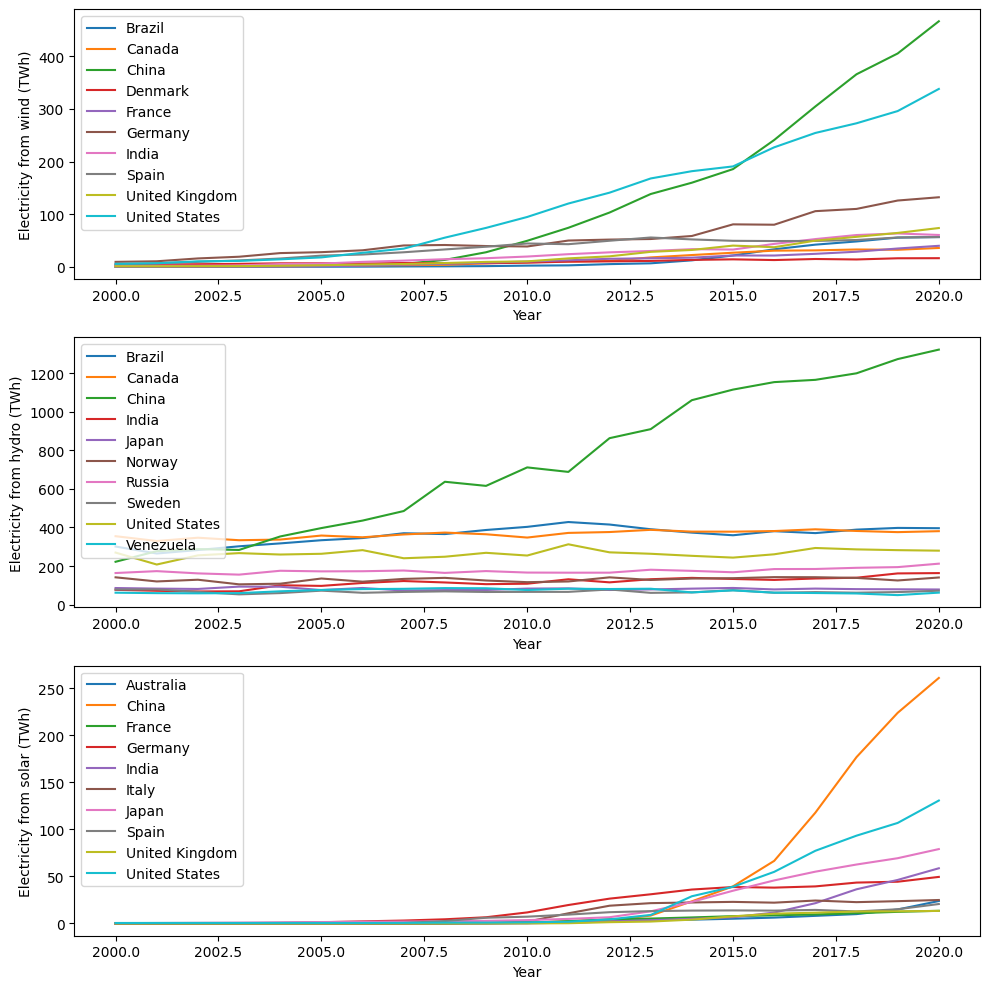

In [ ]:
df_renewable = pd.read_csv("https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/renewable_energy/03%20modern-renewable-prod.csv")

# Filtra as linhas que não tem código (Continentes/Regiões agrupadas)
df_renewable = df_renewable.dropna(subset=['Code'])
df_renewable = df_renewable[df_renewable['Entity'] != 'World']
df_renewable = df_renewable.query("Year >= 2000 and Year <= 2020")

temp = df_renewable.groupby('Entity').sum()

top_wind = (temp
            .nlargest(10, 'Electricity from wind (TWh)')
            .reset_index()['Entity'])

top_hydro = (temp
             .nlargest(10, 'Electricity from hydro (TWh)')
            .reset_index()['Entity'])

top_solar = (temp
             .nlargest(10, 'Electricity from solar (TWh)')
            .reset_index()['Entity'])


fig, ax = plt.subplots(3, 1, figsize=(10, 10))

sns.lineplot(x='Year', y='Electricity from wind (TWh)', hue='Entity', data=df_renewable[df_renewable['Entity'].isin(top_wind)], ax=ax[0])
ax[0].legend(loc='upper left')

sns.lineplot(x='Year', y='Electricity from hydro (TWh)', hue='Entity', data=df_renewable[df_renewable['Entity'].isin(top_hydro)], ax=ax[1])
ax[1].legend(loc='upper left')

sns.lineplot(x='Year', y='Electricity from solar (TWh)', hue='Entity', data=df_renewable[df_renewable['Entity'].isin(top_solar)], ax=ax[2])
ax[2].legend(loc='upper left')


plt.tight_layout()
plt.show()

# Análise do crescimento do uso de energias renováveis e fósseis

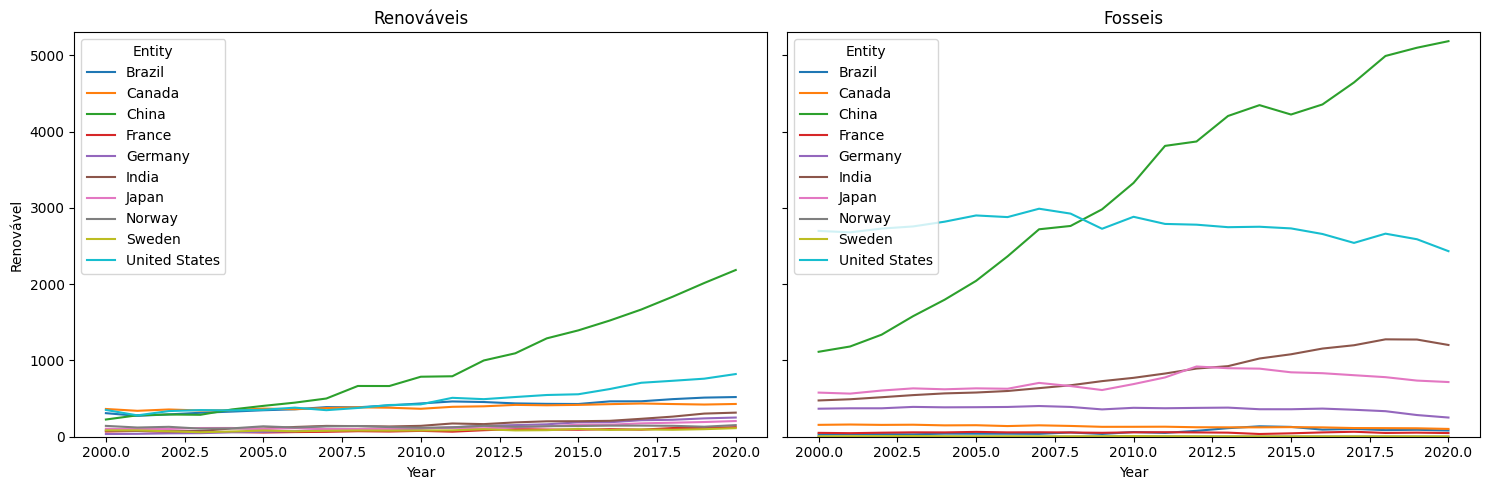

In [ ]:
temp = df1[['Entity', 'Year', 'Electricity from fossil fuels (TWh)', 'Electricity from renewables (TWh)']].groupby('Entity').sum()
top_renew = (temp
            .nlargest(10, 'Electricity from renewables (TWh)')
            .reset_index()['Entity'])

df_comp = (df1[df1['Entity'].isin(top_renew)]
           .rename(columns={'Electricity from renewables (TWh)': 'Renovável', 'Electricity from fossil fuels (TWh)': 'Fóssil'})
           [["Entity", "Year", "Renovável", "Fóssil"]])

fig, ax = plt.subplots(1, 2, figsize=(15, 5), sharey=True)

sns.lineplot(x='Year', y='Renovável', data=df_comp, hue='Entity', ax=ax[0])
ax[0].set_ylim(0, 5300)
ax[0].set_title('Renováveis')


sns.lineplot(x='Year', y='Fóssil', data=df_comp, hue='Entity', ax=ax[1])
ax[1].set_ylim(0, 5300)
ax[1].set_title('Fosseis')


plt.tight_layout()
plt.show()

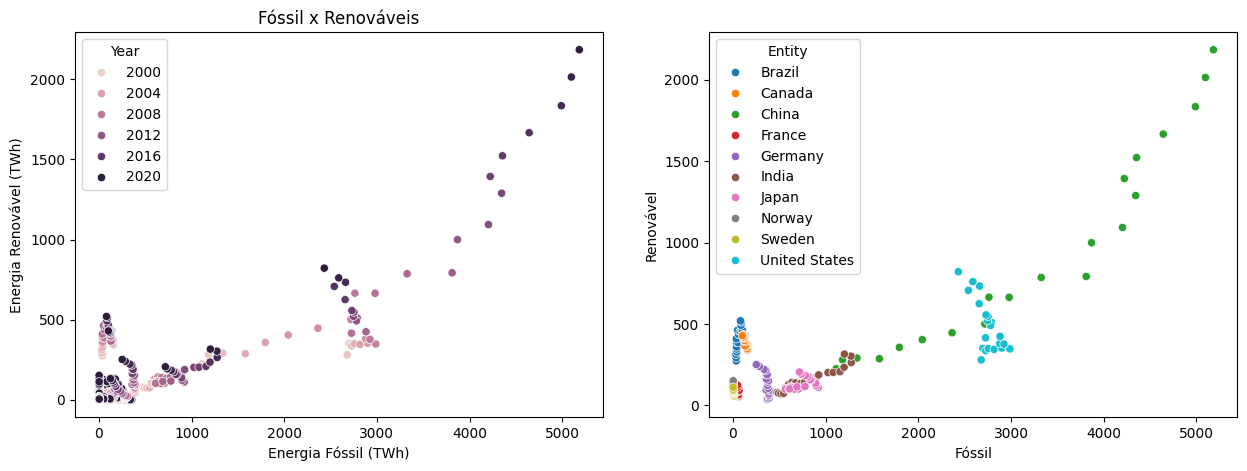

In [ ]:
df_comp = (df1.rename(columns={'Electricity from renewables (TWh)': 'Renovável', 'Electricity from fossil fuels (TWh)': 'Fóssil'})
           [["Entity", "Year", "Renovável", "Fóssil"]])

top_renew = (temp
            .nlargest(10, 'Electricity from renewables (TWh)')
            .reset_index()['Entity'])

top_fossil = (temp
            .nlargest(10, 'Electricity from fossil fuels (TWh)')
            .reset_index()['Entity'])


fig, ax = plt.subplots(1, 2, figsize=(15, 5))

sns.scatterplot(data=df_comp, x='Fóssil', y='Renovável', hue='Year', ax=ax[0])

ax[0].set_title('Fóssil x Renováveis')
ax[0].set_xlabel('Energia Fóssil (TWh)')
ax[0].set_ylabel('Energia Renovável (TWh)')

sns.scatterplot(data=df_comp[df_comp['Entity'].isin(top_renew)], x='Fóssil', y='Renovável', hue='Entity', ax=ax[1])


plt.show()

# PIB dos países (em um determinado ano ou a média histórica) x grau de uso de energias renováveis

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/global-data-on-sustainable-energy.csv")
media_paises = (df[['Entity','Year','Renewable energy share in the total final energy consumption (%)','gdp_per_capita']].
       dropna().
       groupby('Entity').
       mean().
       reset_index()
)
px.scatter(
    data_frame = media_paises,
    x='gdp_per_capita',
    y='Renewable energy share in the total final energy consumption (%)',
    title='PIB per capita X Uso de energia renovável',
    labels={'gdp_per_capita': 'PIB Per Capita (U$)',
            'Renewable energy share in the total final energy consumption (%)':'Uso de energia renovável (%)'},
    width=1080,
    hover_name = 'Entity'
)

No gráfico, cada ponto significa um país, considerando a média tanto do PIB Per Capita quanto do uso de energias renováveis. Podemos notar que o PIB Per Capita não parece ser estar diretamente relacionado com o uso dessas energias, como mostra a grande variação, principalmente, entre países mais pobres.
> Luxemburgo possui um PIB Per Capita de quase 100 mil dólares (o maior do gráfico), mas menos de 7% do seu consumo de energia se origina de fontes renováveis.



In [ ]:
ano = 2019
paises_ano = (
    df[['Entity','Year','Renewable energy share in the total final energy consumption (%)','gdp_per_capita']]
    [df['Year']==ano]
)
px.scatter(
    data_frame = paises_ano,
    x='gdp_per_capita',
    y='Renewable energy share in the total final energy consumption (%)',
    title=f'PIB per capita X Uso de energia renovável ({ano})',
    labels={'gdp_per_capita': 'PIB Per Capita (U$)',
            'Renewable energy share in the total final energy consumption (%)':'Uso de energia renovável (%)'},
    width=1080,
    hover_name = 'Entity',
    color_discrete_sequence=['red']
)

Observando os valores apenas de 2019, podemos notar que os valores não parecem se alterar muito em relação ao gráfico anterior.

# Analisar se o PIB per capita está ligado ao consumo de energia / à produção de energia por fontes renováveis

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/global-data-on-sustainable-energy.csv")
df_sorted = (df[['Entity','Renewable-electricity-generating-capacity-per-capita','Primary energy consumption per capita (kWh/person)','gdp_per_capita']].
           dropna().
           groupby('Entity').
           mean().
           reset_index().
           sort_values(by='gdp_per_capita',ascending=False).
           reset_index(drop=True)
)
df_sorted = df_sorted.assign(Classificacao='Pobres')
df_sorted.loc[:int(len(df_sorted)/2),'Classificacao'] = 'Ricos'

In [ ]:
fig = px.box(data_frame = df_sorted,
             x='Classificacao',
             y='Primary energy consumption per capita (kWh/person)',
             width=1080,
             color='Classificacao',
             title='Distribuição do uso de energia per capita entre países ricos e pobres',
             labels={'Primary energy consumption per capita (kWh/person)': 'Uso de energia (kWh/pessoa)',
                     'Classificacao':'Classificação'}
)
fig.show()

Conforme pode ser visto, a divisão entre países ricos e pobres (metade dos dados para cada lado) mostra que países com PIB per capita acima da mediana possuem uma variação de consumo muito maior, tendo, por exemplo, a mediana próxima ao máximo dos países mais pobres. Logo, parece haver alguma relação entre PIB per capita e consumo de energia per capita.

> **Remover para a apresentação:** O gráfico anterior já meio que fala de pib x uso de grau de consumo de energia de fontes renováveis, então fiz consumo no geral pq ficaria redundante, mas se precisar dá pra mudar

In [ ]:
fig = px.scatter(data_frame = df_sorted,
             x='gdp_per_capita',
             y='Primary energy consumption per capita (kWh/person)',
             width=1080,
             color_discrete_sequence=['green'],
             title='PIB dos países X Uso de energia',
             labels={'Primary energy consumption per capita (kWh/person)': 'Uso de energia (kWh/pessoa)',
                     'gdp_per_capita':'PIB per capita (U$)'},
             hover_name = 'Entity'
)
fig.add_vline(x=df_sorted['gdp_per_capita'].median(),)
fig.show()

Para exibir a ideia do gráfico anterior de outra maneira, a linha vertical deste gráfico divide os países no meio entre a parte mais rica e a mais pobre. Podemos ver que na primeira metade, uma grande quantidade de países se concentra em valores próximos no uso de energia, enquanto na segunda metade os valores se espalham muito mais.

In [ ]:
fig = px.scatter(data_frame = df_sorted,
                 x = 'gdp_per_capita',
                 y = 'Renewable-electricity-generating-capacity-per-capita',
                 width=1080,
                 color_discrete_sequence=['blue'],
                 title='PIB per capita X Capacidade de geração de energia limpa por pessoa',
                 labels={'Renewable-electricity-generating-capacity-per-capita':'Capacidade de geração de energia limpa per capita',
                         'gdp_per_capita':'PIB per capita (U$)'},
                 hover_name = 'Entity'
)

fig.show()

Como podemos ver, não parece haver uma relação muito clara entre PIB per capita e a capacidade dos países de gerar energia de fontes renováveis. A maioria dos países, considerando apenas o eixo Y, estão próximos uns dos outros.

# PIB de alguns países em particular x grau de uso de energias renováveis

Foram escolhidos: Brasil (por ser onde moramos), EUA e China (por serem os dois maiores países do mundo) e Luxemburgo (porque achei curioso o fato de ter um PIB per capita alto e baixo uso de energia por fontes renováveis)

In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/global-data-on-sustainable-energy.csv")
fig = make_subplots(rows = 4,
                    cols = 2,
                    subplot_titles=['PIB per Capita (U$)','% da participação da energias renováveis'],
                    row_titles=['Brasil','EUA','China','Luxemburgo']
)

index = {1:'Brazil',2:'United States',3:'China',4:'Luxembourg'}

colors = {1:'#00ad00',2:'#1f77b4',3:'#ff0000',4:'#3182EB'}

for i in index:
  df1 = df[df['Entity']==index[i]].dropna(subset=['Year','Renewable energy share in the total final energy consumption (%)','gdp_per_capita'])
  fig1 = px.line(data_frame = df1,x='Year',y='Renewable energy share in the total final energy consumption (%)')
  fig2 = px.line(data_frame = df1, x = 'Year',y='gdp_per_capita')
  fig1.update_traces(line_color=colors[i])
  fig2.update_traces(line_color=colors[i])
  for trace in fig1.data:
    fig.add_trace(trace,row=i,col=2)

  for trace in fig2.data:
    fig.add_trace(trace, row=i, col=1)


fig.update_layout(
    autosize=False,
    width=1720,
    height=720
)

fig.show()

Como pode ser observado, dentre os países selecionados, alguns parecem ter uma certa relação entre o crescimento do PIB per capita e o uso de energias renováveis, como o Brasil e os EUA. Entretanto, podemos notar que na China, aparentemente, o oposto ocorreu. Em Luxemburgo,a participação dessas energias aumentou, mas permanece baixa (ainda mais considerando o seu alto PIB per capita).

# Análises mais voltadas para o Brasil



In [ ]:
df = pd.read_csv("https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/global-data-on-sustainable-energy.csv")
dfBR = df[df['Entity']=='Brazil'].dropna()

fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=['PIB per Capita por ano no Brasil',
                    'Participação de energias de baixo carbono no Brasil (%)',
                    'Porcentagem da população brasileira com acesso à energia elétrica',
                    'Consumo de energia elétrica per capita por ano no Brasil (kWh)'],
)

index = {0:'gdp_per_capita',
         1:'Access to electricity (% of population)',
         2:'Low-carbon electricity (% electricity)',
         3:'Primary energy consumption per capita (kWh/person)'
}
colors = {0:'#138c00',1:'#aca853',2:'#494844',3:'#b90000'}
l=1
c=1

for i in index:
  fig1 = px.line(data_frame = dfBR,x='Year',y=index[i],)
  fig1.update_traces(line_color=colors[i])

  for trace in fig1.data:
    fig.add_trace(trace,row=l,col=c)

  if l==2:
    l=1
    c+=1
  else:
    l=2

fig.update_layout(
    autosize=False,
    width=1720,
    height=720
)

fig.show()

## Testando a conclusão abaixo

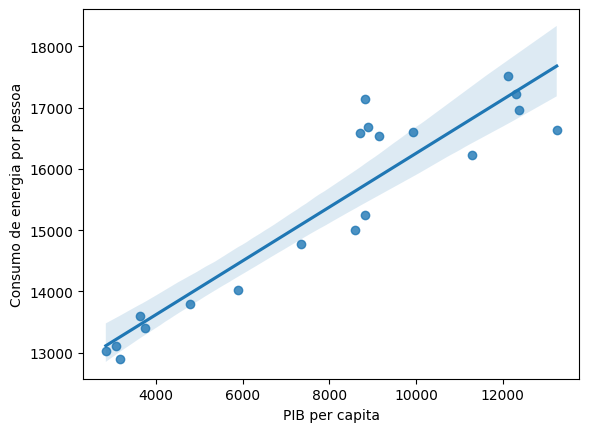

In [ ]:
fig = sns.regplot(data=dfBR, x=index[0], y=index[3])
fig.set(xlabel='PIB per capita', ylabel = 'Consumo de energia por pessoa')
plt.show()

Analisando os gráficos acima sobre o Brasil, podemos percerber que o PIB per Capita e o consumo de energia por pessoa parecem relacionados. O gráfico da participação de energias de baixo carbono mostra que, a partir de 2011, o uso de energias de baixo carbono diminuiu e voltou a se recuperar em 2015, mas ainda não foi o suficiente para se equiparar aos valores antigos (ao menos até 2019). Por fim, percebemos que a taxa da população com acesso à energia elétrica cresceu quase em todos os anos, tendo alcançado 99.8% da populaão em 2019.

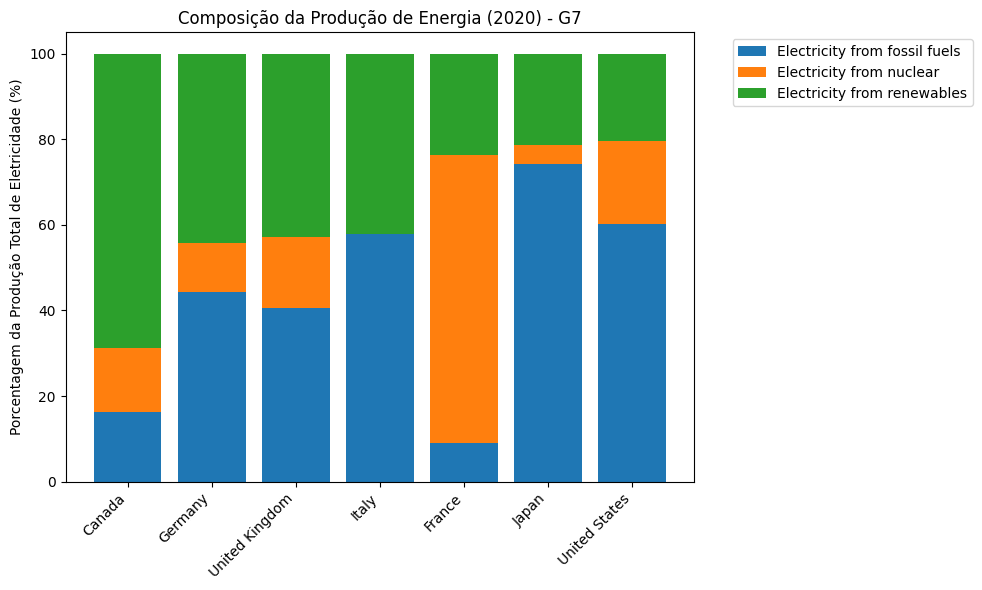

In [ ]:
# Carrega o dataset
data = pd.read_csv("https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/global-data-on-sustainable-energy.csv")

# Lista dos países do G7
g7_countries = ['Canada', 'France', 'Germany', 'Italy', 'Japan', 'United Kingdom', 'United States']

# Nova coluna para classificar os países
def classify_country(country):
    if country in g7_countries:
        return 'G7'
    else:
        return 'Other'

data['Group'] = data['Entity'].apply(classify_country)

# Dados para 2020
data_2020 = data[data['Year'] == 2020]
data_2020.loc[:, 'Total Electricity (TWh)'] = data_2020[['Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)', 'Electricity from renewables (TWh)']].sum(axis=1)

# Ordenar por maior produção de energia renovável
data_2020 = data_2020.sort_values('Electricity from renewables (TWh)', ascending=False)

# Calcula as porcentagens usando .loc
for source in ['Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)', 'Electricity from renewables (TWh)']:
    data_2020.loc[:, source + ' (%)'] = data_2020[source] / data_2020['Total Electricity (TWh)'] * 100

# Preparar dados classificados para gráficos
g7_data_2020 = data_2020[data_2020['Group'] == 'G7']

# Ordenar dados pela maior utilização de energias renováveis (%)
g7_data_2020 = g7_data_2020.sort_values('Electricity from renewables (TWh) (%)', ascending=False)

# Plotar o gráfico de barras empilhadas para o G7
plt.figure(figsize=(10, 6))

# g7_data_2020 = g7_data_2020.rename(columns={
#     'Electricity from renewables (TWh) (%)': 'Fontes renováveis (TWh) (%)',
#     'Electricity from fossil fuels (TWh) (%)': 'Combustíveis fósseis (TWh) (%)',
#     'Electricity from nuclear (TWh) (%)': 'Nuclear (TWh) (%)'
#     })
# print(g7_data_2020.columns)

bottom = np.zeros(len(g7_data_2020))
for source in ['Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)', 'Electricity from renewables (TWh)']:
    plt.bar(g7_data_2020['Entity'], g7_data_2020[source + ' (%)'], bottom=bottom, label=source.split(' (')[0])
    bottom += g7_data_2020[source + ' (%)']

plt.title('Composição da Produção de Energia (2020) - G7')
plt.ylabel('Porcentagem da Produção Total de Eletricidade (%)')
plt.xticks(rotation=45, ha='right')

# Coloca a legenda fora do gráfico
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()

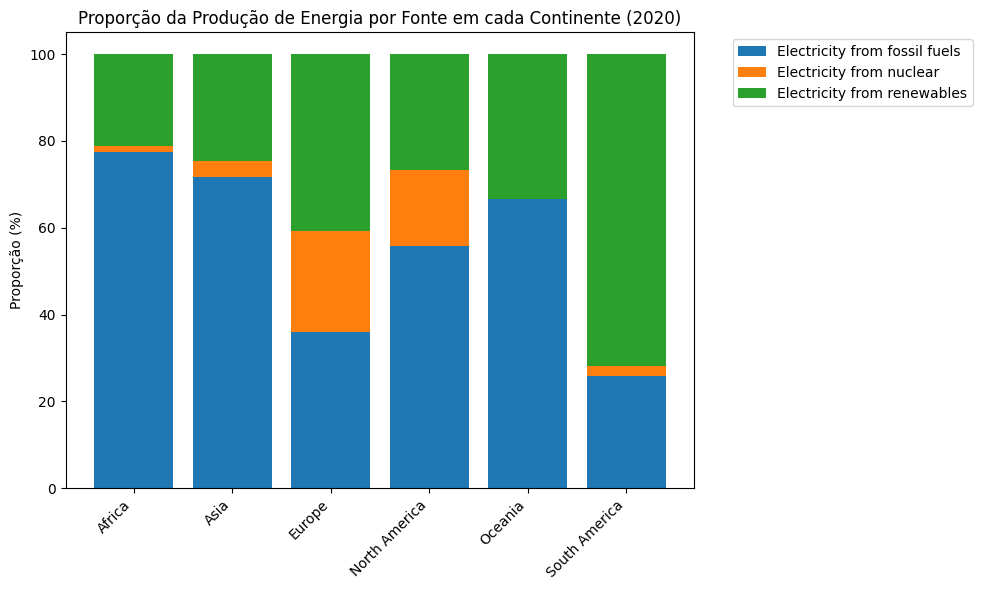

In [ ]:
# Lista dos continentes (adicionar manualmente)
continentes = {
    'North America': ['Antigua and Barbuda', 'Aruba', 'Bahamas', 'Barbados', 'Belize', 'Bermuda', 'Canada', 'Cayman Islands', 'Costa Rica', 'Cuba', 'Dominica', 'Dominican Republic', 'El Salvador', 'Greenland', 'Grenada', 'Guatemala', 'Haiti', 'Honduras', 'Jamaica', 'Mexico', 'Nicaragua', 'Panama', 'Puerto Rico', 'Saint Kitts and Nevis', 'Saint Lucia', 'Saint Vincent and the Grenadines', 'Trinidad and Tobago', 'United States'],
    'South America': ['Argentina', 'Bolivia', 'Brazil', 'Chile', 'Colombia', 'Ecuador', 'Guyana', 'Paraguay', 'Peru', 'Suriname', 'Uruguay', 'Venezuela'],
    'Europe': ['Albania', 'Andorra', 'Austria', 'Belarus', 'Belgium', 'Bosnia and Herzegovina', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark', 'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Iceland', 'Ireland', 'Italy', 'Latvia', 'Liechtenstein', 'Lithuania', 'Luxembourg', 'Malta', 'Monaco', 'Montenegro', 'Netherlands', 'North Macedonia', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'San Marino', 'Serbia', 'Slovakia', 'Slovenia', 'Spain', 'Sweden', 'Switzerland', 'Ukraine', 'United Kingdom'],
    'Asia': ['Afghanistan', 'Armenia', 'Azerbaijan', 'Bahrain', 'Bangladesh', 'Bhutan', 'Brunei', 'Cambodia', 'China', 'Georgia', 'Hong Kong', 'India', 'Indonesia', 'Iran', 'Iraq', 'Israel', 'Japan', 'Jordan', 'Kazakhstan', 'Kuwait', 'Kyrgyzstan', 'Laos', 'Lebanon', 'Malaysia', 'Maldives', 'Mongolia', 'Myanmar', 'Nepal', 'Oman', 'Pakistan', 'Philippines', 'Qatar', 'Saudi Arabia', 'Singapore', 'South Korea', 'Sri Lanka', 'Syria', 'Taiwan', 'Tajikistan', 'Thailand', 'Turkey', 'Turkmenistan', 'United Arab Emirates', 'Uzbekistan', 'Vietnam', 'Yemen'],
    'Africa': ['Algeria', 'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde', 'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo', 'Cote dIvoire', "Democratic Republic of the Congo", 'Djibouti', 'Egypt', 'Equatorial Guinea', 'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Gambia', 'Ghana', 'Guinea', 'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Libya', 'Madagascar', 'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Morocco', 'Mozambique', 'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Sao Tome and Principe', 'Senegal', 'Seychelles', 'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 'Tanzania', 'Togo', 'Tunisia', 'Uganda', 'Zambia', 'Zimbabwe'],
    'Oceania': ['Australia', 'Fiji', 'Kiribati', 'Marshall Islands', 'Micronesia', 'Nauru', 'New Caledonia', 'New Zealand', 'Palau', 'Papua New Guinea', 'Samoa', 'Solomon Islands', 'Tonga', 'Tuvalu', 'Vanuatu']
}

# Cria uma nova coluna 'Continent' no DataFrame
data['Continent'] = data['Entity'].apply(lambda x: next((continente for continente, paises in continentes.items() if x in paises), None))

# Filtra os dados para o ano de 2020
data_2020 = data[data['Year'] == 2020]

# Calcula a produção total de eletricidade por país antes de agrupar
data_2020['Total Electricity (TWh)'] = data_2020[['Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)', 'Electricity from renewables (TWh)']].sum(axis=1)

# Agrupa os dados por continente e calcula a soma da produção de energia por fonte
continent_energy = data_2020.groupby('Continent')[['Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)', 'Electricity from renewables (TWh)', 'Total Electricity (TWh)']].sum() # Inclui 'Total Electricity (TWh)' no agrupamento

# Calcula a proporção de cada fonte de energia
for source in ['Electricity from fossil fuels (TWh)', 'Electricity from nuclear (TWh)', 'Electricity from renewables (TWh)']:
    continent_energy[source + ' (%)'] = continent_energy[source] / continent_energy['Total Electricity (TWh)'] * 100

# Plota o gráfico de barras empilhadas para cada continente com as proporções
plt.figure(figsize=(10, 6))

bottom = np.zeros(len(continent_energy))
for source in ['Electricity from fossil fuels (TWh) (%)', 'Electricity from nuclear (TWh) (%)', 'Electricity from renewables (TWh) (%)']:
    plt.bar(continent_energy.index, continent_energy[source], bottom=bottom, label=source.split(' (')[0].replace(' (%)', ''))
    bottom += continent_energy[source]

plt.title('Proporção da Produção de Energia por Fonte em cada Continente (2020)')
plt.ylabel('Proporção (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

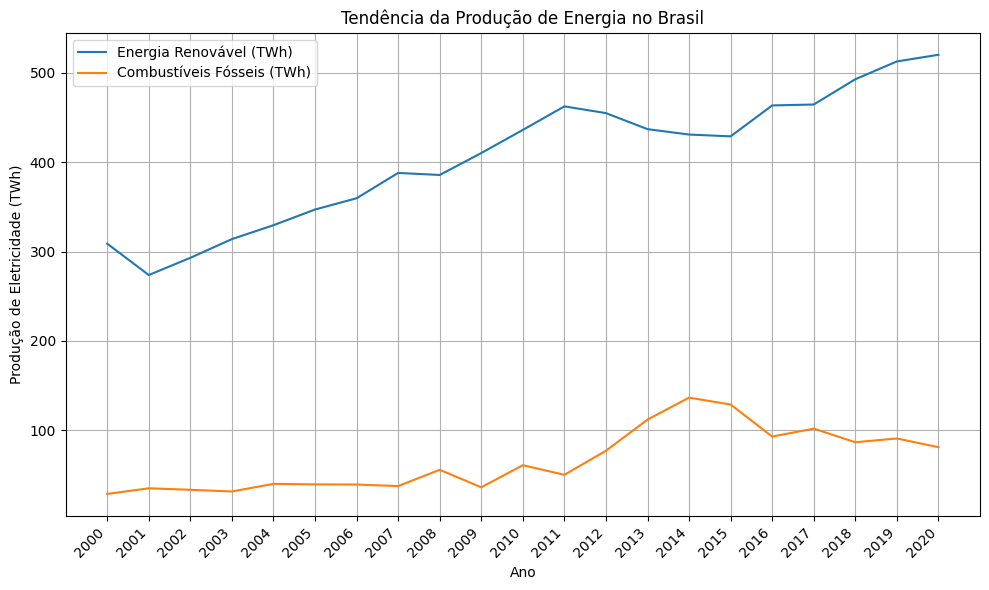

In [ ]:
# Tendência da Produção de Energia Renovável e Uso de Combustíveis Fósseis no Brasil
data_brasil = data[data['Entity'] == 'Brazil']
plt.figure(figsize=(10, 6))

# Converte a coluna 'Year' para inteiros usando .loc
data_brasil.loc[:, 'Year'] = data_brasil['Year'].astype(int)

plt.plot(data_brasil['Year'], data_brasil['Electricity from renewables (TWh)'], label='Energia Renovável (TWh)')
plt.plot(data_brasil['Year'], data_brasil['Electricity from fossil fuels (TWh)'], label='Combustíveis Fósseis (TWh)')

plt.title('Tendência da Produção de Energia no Brasil')
plt.xlabel('Ano')
plt.ylabel('Produção de Eletricidade (TWh)')
plt.xticks(data_brasil['Year'].unique(), rotation=45, ha='right')

plt.legend()
plt.grid(True)
plt.tight_layout() # Ajusta o layout para evitar sobreposição de elementos
plt.show()

## Verificar possível correlação entre Área do País/Grau de Desenvolvimento/Latitude com a produção de energia solar

In [ ]:
df1 = pd.read_csv("https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/global-data-on-sustainable-energy.csv")
df_solar = pd.read_csv("https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/renewable_energy/12%20solar-energy-consumption.csv")
df_idh = pd.read_csv("https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/human-development-index.csv")

In [ ]:
year = 2020
df_solar = df_solar.query(f"Year == {year}")
df1 = df1.query(f"Year == {year}")
df_idh = df_idh.query(f"Year == {year}")

# Merge the latitude column in this table
df_solar = df_solar.merge(df1[['Entity', 'Latitude', 'Land Area(Km2)']], left_on='Entity', right_on='Entity')
df_solar = df_solar.merge(df_idh[['Entity', 'Human Development Index']], left_on='Entity', right_on='Entity')

#df_solar.sort_values(by='Land Area(Km2)', ascending=False)

### Como os países estão distribuídos em relação a esses atributos

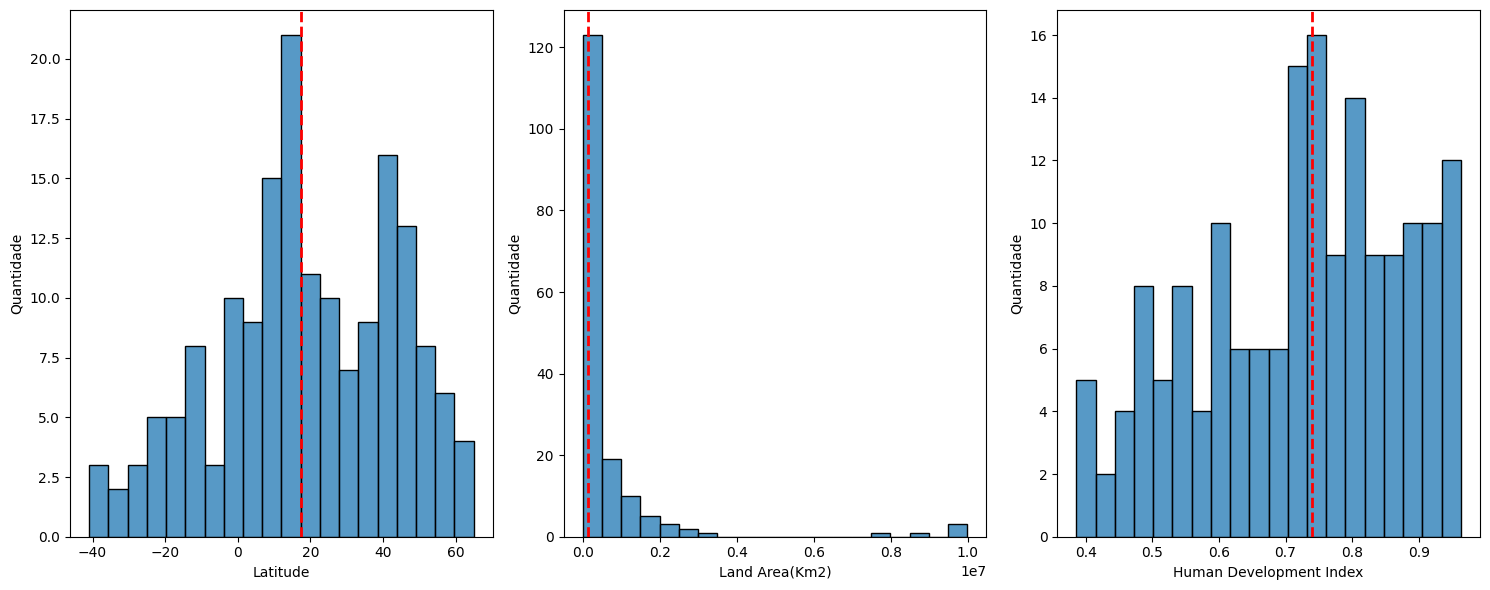

In [ ]:
median_lat = df_solar['Latitude'].median()
median_land_area = df_solar['Land Area(Km2)'].median()

fig, ax = plt.subplots(1, 3, figsize=(15, 6))

sns.histplot(df_solar['Latitude'], bins=20, ax=ax[0])
ax[0].axvline(median_lat, color='red', linestyle='dashed', linewidth=2)
ax[0].set_xlabel("Latitude")
ax[0].set_ylabel("Quantidade")

sns.histplot(df_solar['Land Area(Km2)'], bins=20, ax=ax[1])
ax[1].axvline(median_land_area, color='red', linestyle='dashed', linewidth=2)
ax[1].set_xlabel("Land Area(Km2)")
ax[1].set_ylabel("Quantidade")


sns.histplot(df_solar['Human Development Index'], bins=20, ax=ax[2])
ax[2].axvline(df_solar['Human Development Index'].median(), color='red', linestyle='dashed', linewidth=2)
ax[2].set_xlabel("Human Development Index")
ax[2].set_ylabel("Quantidade")

plt.tight_layout()
plt.show()

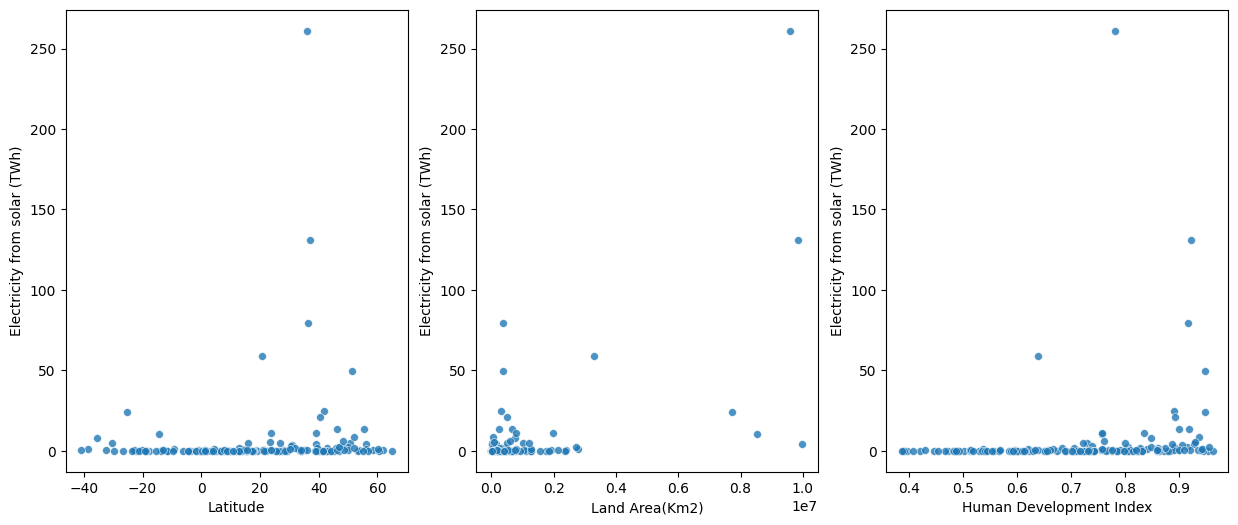

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.scatterplot(data=df_solar, x='Latitude', y='Electricity from solar (TWh)', s=32, alpha=.8, ax=ax[0])
sns.scatterplot(data=df_solar, x='Land Area(Km2)', y='Electricity from solar (TWh)', s=32, alpha=.8, ax=ax[1])
sns.scatterplot(data=df_solar, x='Human Development Index', y='Electricity from solar (TWh)', s=32, alpha=.8, ax=ax[2])

plt.show()

Nos plots anteriores, é possível observar que não existe uma correlação aparente entre os atributos observados. Nota-se também que há uma concentração grande de países com pouca área total disponível, o que pode atrapalhar a análise. Dessa forma foi isolado esse grupo nos plots abaixo:

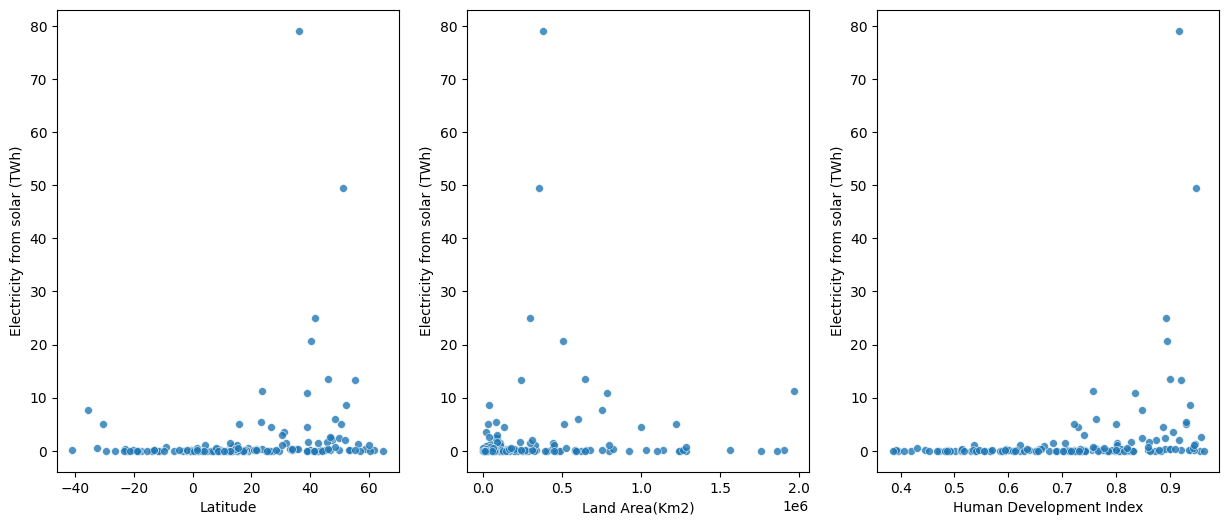

In [ ]:

df_solar_lim = df_solar[df_solar['Land Area(Km2)'] < 2 * 1e6].copy()
fig, ax = plt.subplots(1, 3, figsize=(15, 6))
sns.scatterplot(data=df_solar_lim, x='Latitude', y='Electricity from solar (TWh)', s=32, alpha=.8, ax=ax[0])
sns.scatterplot(data=df_solar_lim, x='Land Area(Km2)', y='Electricity from solar (TWh)', s=32, alpha=.8, ax=ax[1])
sns.scatterplot(data=df_solar_lim, x='Human Development Index', y='Electricity from solar (TWh)', s=32, alpha=.8, ax=ax[2])

plt.show()

E novamente, não foi observado nenhuma correlação entre esses atributos.

#Regressões:

## Prever dados de produção de energia a partir de combustíveis fósseis e fontes renováveis do Brasil em 10 anos

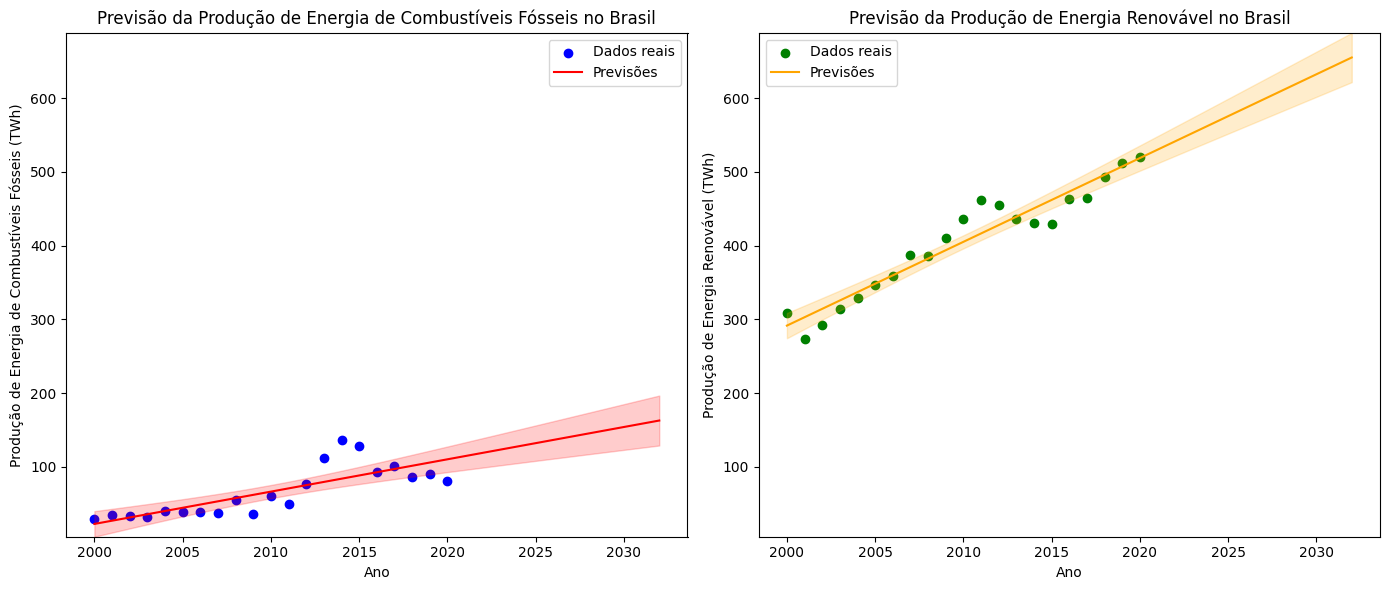

In [ ]:
from sklearn.linear_model import LinearRegression

# Carregar os dados
global_data = pd.read_csv("https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/global-data-on-sustainable-energy.csv")
brazil_data = global_data[global_data['Entity'] == 'Brazil']

# Selecionar as colunas de interesse e remover linhas com valores ausentes
brazil_data = brazil_data[['Year', 'Electricity from fossil fuels (TWh)', 'Electricity from renewables (TWh)']].dropna()

# Definir variáveis independentes (anos) e dependentes (produção de energia)
X = brazil_data['Year'].values.reshape(-1, 1)
y_fossil = brazil_data['Electricity from fossil fuels (TWh)'].values
y_renewables = brazil_data['Electricity from renewables (TWh)'].values

# Ajustar modelos de regressão linear
model_fossil = LinearRegression().fit(X, y_fossil)
model_renewables = LinearRegression().fit(X, y_renewables)

# Prever para os próximos 10 anos
future_years = np.array([2023 + i for i in range(10)]).reshape(-1, 1)
all_years = np.append(X, future_years).reshape(-1, 1)
fossil_pred_all = model_fossil.predict(all_years)
renewables_pred_all = model_renewables.predict(all_years)

# Calcular os IC 95%
def calculate_confidence_interval(model, X, y, X_all, confidence=0.95):
    y_pred = model.predict(X)
    residual = y - y_pred
    mean_x = np.mean(X)
    n = len(X)
    t = 1.96  # valor t para a confiança de 95% e graus de liberdade grandes
    s_err = np.sqrt(np.sum(residual**2) / (n - 2))
    interval = t * s_err * np.sqrt(1/n + (X_all.flatten() - mean_x)**2 / np.sum((X - mean_x)**2))
    return interval.flatten()

# IC para combustíveis fósseis
fossil_intervals_all = calculate_confidence_interval(model_fossil, X, y_fossil, all_years)

# IC para renováveis
renewables_intervals_all = calculate_confidence_interval(model_renewables, X, y_renewables, all_years)

# Obter limites do gráfico para manter as escalas semelhantes
min_fossil = np.min(np.concatenate((y_fossil, fossil_pred_all - fossil_intervals_all)))
max_fossil = np.max(np.concatenate((y_fossil, fossil_pred_all + fossil_intervals_all)))
min_renewables = np.min(np.concatenate((y_renewables, renewables_pred_all - renewables_intervals_all)))
max_renewables = np.max(np.concatenate((y_renewables, renewables_pred_all + renewables_intervals_all)))

overall_min = min(min_fossil, min_renewables)
overall_max = max(max_fossil, max_renewables)

# Plotar as previsões
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.scatter(X, y_fossil, color='blue', label='Dados reais')
plt.plot(all_years, fossil_pred_all, color='red', label='Previsões')
plt.fill_between(all_years.flatten(), fossil_pred_all - fossil_intervals_all, fossil_pred_all + fossil_intervals_all, color='red', alpha=0.2)
plt.xlabel('Ano')
plt.ylabel('Produção de Energia de Combustíveis Fósseis (TWh)')
plt.title('Previsão da Produção de Energia de Combustíveis Fósseis no Brasil')
plt.legend()
plt.ylim(overall_min, overall_max)

plt.subplot(1, 2, 2)
plt.scatter(X, y_renewables, color='green', label='Dados reais')
plt.plot(all_years, renewables_pred_all, color='orange', label='Previsões')
plt.fill_between(all_years.flatten(), renewables_pred_all - renewables_intervals_all, renewables_pred_all + renewables_intervals_all, color='orange', alpha=0.2)
plt.xlabel('Ano')
plt.ylabel('Produção de Energia Renovável (TWh)')
plt.title('Previsão da Produção de Energia Renovável no Brasil')
plt.legend()
plt.ylim(overall_min, overall_max)

plt.tight_layout()
plt.show()

Digite o ano para previsão de produção de energia: 2030
Previsão para o ano 2030:
Produção de energia por combustíveis fósseis: 154.20 TWh (19.60%)
Produção de energia por fontes renováveis: 632.55 TWh (80.40%)


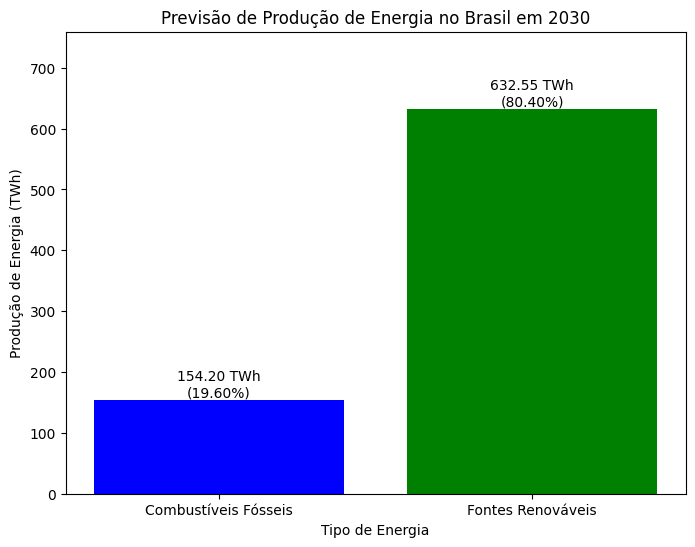

In [ ]:
# Função para prever a produção de energia para um ano dado e plotar gráfico
def predict_and_plot_energy_production(year):
    year_array = np.array([[year]])
    fossil_pred = model_fossil.predict(year_array)[0]
    renewables_pred = model_renewables.predict(year_array)[0]
    total_energy = fossil_pred + renewables_pred
    fossil_percentage = (fossil_pred / total_energy) * 100
    renewables_percentage = (renewables_pred / total_energy) * 100

    # Exibir os valores previstos
    print(f"Previsão para o ano {year}:")
    print(f"Produção de energia por combustíveis fósseis: {fossil_pred:.2f} TWh ({fossil_percentage:.2f}%)")
    print(f"Produção de energia por fontes renováveis: {renewables_pred:.2f} TWh ({renewables_percentage:.2f}%)")

    # Plotar o gráfico
    categories = ['Combustíveis Fósseis', 'Fontes Renováveis']
    values = [fossil_pred, renewables_pred]
    percentages = [fossil_percentage, renewables_percentage]

    plt.figure(figsize=(8, 6))
    plt.bar(categories, values, color=['blue', 'green'])
    plt.xlabel('Tipo de Energia')
    plt.ylabel('Produção de Energia (TWh)')
    plt.title(f'Previsão de Produção de Energia no Brasil em {year}')
    for i in range(len(categories)):
      plt.text(i, values[i], f'{values[i]:.2f} TWh\n({percentages[i]:.2f}%)', ha='center', va='bottom')
    plt.ylim(0, max(values) * 1.2)
    plt.show()

year = int(input("Digite o ano para previsão de produção de energia: "))
predict_and_plot_energy_production(year)

## Dado o PIB per capita fazer uma regressão para prever o consumo de energia total para Brasil

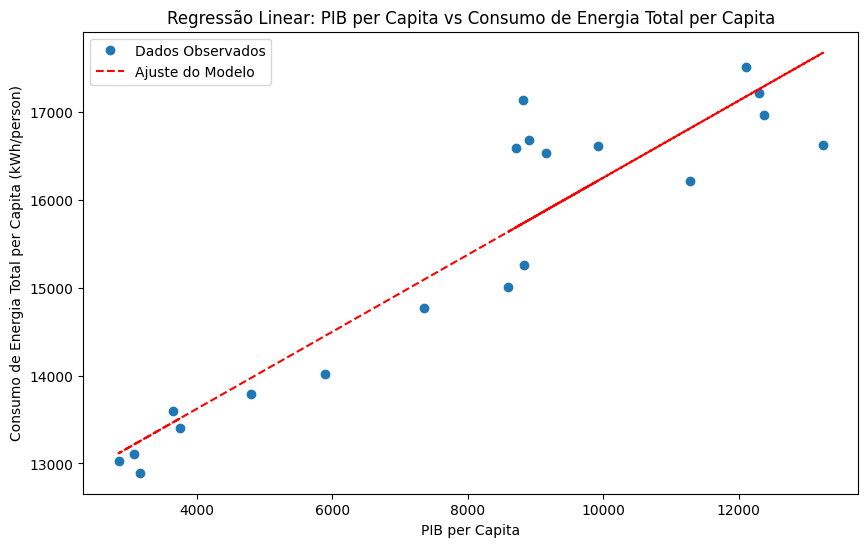

                                            OLS Regression Results                                            
Dep. Variable:     Primary energy consumption per capita (kWh/person)   R-squared:                       0.862
Model:                                                            OLS   Adj. R-squared:                  0.854
Method:                                                 Least Squares   F-statistic:                     112.1
Date:                                                Fri, 09 Aug 2024   Prob (F-statistic):           3.69e-09
Time:                                                        04:30:45   Log-Likelihood:                -156.07
No. Observations:                                                  20   AIC:                             316.1
Df Residuals:                                                      18   BIC:                             318.1
Df Model:                                                           1                                         
C

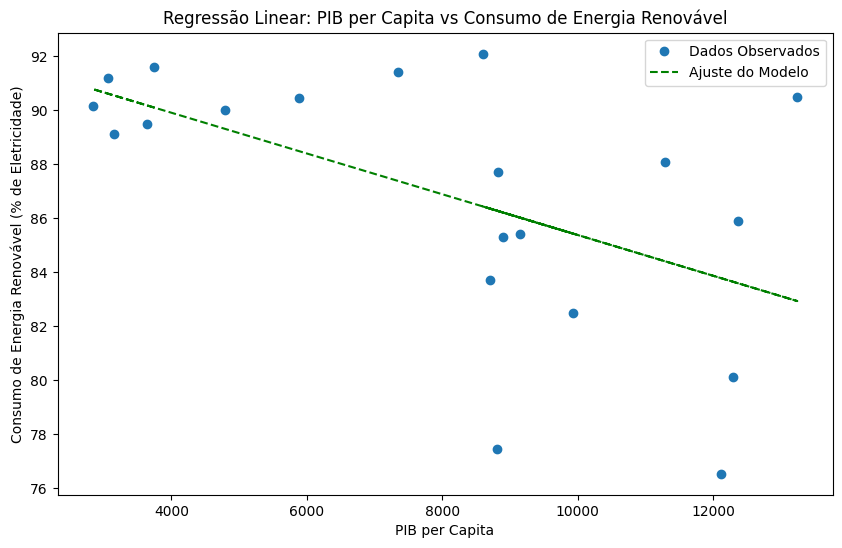

                                      OLS Regression Results                                      
Dep. Variable:     Low-carbon electricity (% electricity)   R-squared:                       0.305
Model:                                                OLS   Adj. R-squared:                  0.267
Method:                                     Least Squares   F-statistic:                     7.904
Date:                                    Fri, 09 Aug 2024   Prob (F-statistic):             0.0116
Time:                                            04:30:46   Log-Likelihood:                -55.289
No. Observations:                                      20   AIC:                             114.6
Df Residuals:                                          18   BIC:                             116.6
Df Model:                                               1                                         
Covariance Type:                                nonrobust                                         
          

In [ ]:
import statsmodels.api as sm

# Consumo de Energia Total per Capita
X_total = dfBR['gdp_per_capita']
y_total = dfBR['Primary energy consumption per capita (kWh/person)']

# Adiciona uma constante (termo de interceptação) ao modelo
X_total = sm.add_constant(X_total)

# Ajusta o modelo de regressão linear
model_total = sm.OLS(y_total, X_total).fit()

# Previsões e Intervalos de Confiança
predictions_total = model_total.get_prediction(X_total)
summary_frame_total = predictions_total.summary_frame()

# Gráficos de regressão com intervalos de confiança
plt.figure(figsize=(10, 6))
plt.plot(dfBR['gdp_per_capita'], y_total, 'o', label="Dados Observados")
plt.plot(dfBR['gdp_per_capita'], model_total.fittedvalues, 'r--', label="Ajuste do Modelo")
# plt.fill_between(dfBR['gdp_per_capita'], summary_frame_total['obs_ci_lower'], summary_frame_total['obs_ci_upper'], color='gray', alpha=0.3, label="Intervalo de Confiança")
plt.xlabel('PIB per Capita')
plt.ylabel('Consumo de Energia Total per Capita (kWh/person)')
plt.legend(loc='best')
plt.title('Regressão Linear: PIB per Capita vs Consumo de Energia Total per Capita')
plt.show()

print(model_total.summary())

# Consumo de Energia Renovável (% de Eletricidade)
X_renewable = dfBR['gdp_per_capita']
y_renewable = dfBR['Low-carbon electricity (% electricity)']

# Adiciona uma constante (termo de interceptação) ao modelo
X_renewable = sm.add_constant(X_renewable)

# Ajusta o modelo de regressão linear
model_renewable = sm.OLS(y_renewable, X_renewable).fit()

# Previsões e Intervalos de Confiança
predictions_renewable = model_renewable.get_prediction(X_renewable)
summary_frame_renewable = predictions_renewable.summary_frame()

# Gráficos de regressão com intervalos de confiança
plt.figure(figsize=(10, 6))
plt.plot(dfBR['gdp_per_capita'], y_renewable, 'o', label="Dados Observados")
plt.plot(dfBR['gdp_per_capita'], model_renewable.fittedvalues, 'g--', label="Ajuste do Modelo")
# plt.fill_between(dfBR['gdp_per_capita'], summary_frame_renewable['obs_ci_lower'], summary_frame_renewable['obs_ci_upper'], color='gray', alpha=0.3, label="Intervalo de Confiança")
plt.xlabel('PIB per Capita')
plt.ylabel('Consumo de Energia Renovável (% de Eletricidade)')
plt.legend(loc='best')
plt.title('Regressão Linear: PIB per Capita vs Consumo de Energia Renovável')
plt.show()

print(model_renewable.summary())

A análise do modelo de regressão mostra que o PIB per capita é um bom preditor para o consumo de energia total per capita. No entanto, a relação entre PIB per capita e consumo de energia renovável é mais incerta, conforme indicado pelo intervalo de confiança mais amplo. Essas diferenças podem ser devidas à complexidade das variáveis que afetam o consumo de energia renovável, que podem não estar diretamente relacionadas ao PIB per capita.

## Prever a quantidade de poluentes emitida por cada país

Nesse momento, realizaremos o tratamento de uma das bases de dados (com limpeza e engenharia de atributos) a fim de prepará-la para o treinamento de um modelo de aprendizado baseado em regressão multivariada com regularização.

In [ ]:
# Limpando e transformando a base:
new_global_data = global_data.copy()

new_global_data =  new_global_data.rename(columns={'Entity': 'Country'})
new_global_data['Financial flows to developing countries (US $)'] = new_global_data['Financial flows to developing countries (US $)'].fillna(0)

countries_with_missing_gdp_growth_rate = new_global_data.groupby('Country')['gdp_growth'].sum().reset_index()
countries_with_missing_gdp_growth_rate = countries_with_missing_gdp_growth_rate.query('gdp_growth == 0')

countries_with_missing_gdp_per_capita = new_global_data.groupby('Country')['gdp_per_capita'].sum().reset_index()
countries_with_missing_gdp_per_capita = countries_with_missing_gdp_per_capita.query('gdp_per_capita == 0')

new_global_data = new_global_data[~new_global_data['Country'].isin(countries_with_missing_gdp_growth_rate['Country'])]
new_global_data = new_global_data[~new_global_data['Country'].isin(countries_with_missing_gdp_per_capita['Country'])]

new_global_data.dropna(subset=['Access to electricity (% of population)',
                                'Access to clean fuels for cooking',
                                'Renewable energy share in the total final energy consumption (%)',
                                'Electricity from fossil fuels (TWh)',
                                'Electricity from nuclear (TWh)',
                                'Electricity from renewables (TWh)',
                                'Low-carbon electricity (% electricity)',
                                'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
                                'Value_co2_emissions_kt_by_country'
                               ], inplace=True)

new_global_data['gdp_growth'] = new_global_data['gdp_growth'].fillna(new_global_data.groupby('Country')['gdp_growth'].transform('mean'))
new_global_data['gdp_per_capita'] = new_global_data['gdp_per_capita'].fillna(new_global_data.groupby('Country')['gdp_per_capita'].transform('mean'))

new_global_data['Density\\n(P/Km2)']  = new_global_data['Density\\n(P/Km2)'].apply(lambda x: x.replace(',','.'))
new_global_data['Density\\n(P/Km2)'] = new_global_data['Density\\n(P/Km2)'].astype(float)

new_global_data  = new_global_data.drop(['Renewables (% equivalent primary energy)',
                                         'Renewable-electricity-generating-capacity-per-capita',
                                         'Country',
                                         'Year',
                                         'Latitude',
                                         'Longitude',
                                         'Density\\n(P/Km2)',
                                         'Land Area(Km2)',
                                         'Electricity from fossil fuels (TWh)',
                                         'Energy intensity level of primary energy (MJ/$2017 PPP GDP)',
                                         ], axis=1)

new_global_data.isnull().sum()

,0
Access to electricity (% of population),0
Access to clean fuels for cooking,0
Financial flows to developing countries (US $),0
Renewable energy share in the total final energy consumption (%),0
Electricity from nuclear (TWh),0
Electricity from renewables (TWh),0
Low-carbon electricity (% electricity),0
Primary energy consumption per capita (kWh/person),0
Value_co2_emissions_kt_by_country,0
gdp_growth,0


In [ ]:
# Fazendo One-Hot Encoding das variáveis categóricas

new_global_data = pd.get_dummies(new_global_data)

In [ ]:
# Realizando a divisão entre dados de treino e dados de teste
from sklearn.model_selection import train_test_split

X = new_global_data.copy()
X = X.drop('Value_co2_emissions_kt_by_country', axis=1)
y = new_global_data['Value_co2_emissions_kt_by_country']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2332, 10), (584, 10), (2332,), (584,))

In [ ]:
# Z-normalizando as colunas do treino e do teste com a média e o desvio-padrão do treino

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

numerical_columns = []

for i, col in enumerate(new_global_data.columns):
  if new_global_data.dtypes[i] != 'object':
    numerical_columns.append(col)

numerical_columns.remove('Value_co2_emissions_kt_by_country')

mean_train = X_train[numerical_columns].mean()
std_train = X_train[numerical_columns].std(ddof=1)

D_train = X_train.copy()
D_train[numerical_columns] = X_train[numerical_columns] - mean_train
D_train[numerical_columns] = D_train[numerical_columns] / std_train

D_test = X_test.copy()
D_test[numerical_columns] = X_test[numerical_columns] - mean_train
D_test[numerical_columns] = D_test[numerical_columns] / std_train

D_train.shape, y_train.shape, D_test.shape, y_test.shape

((2332, 10), (2332,), (584, 10), (584,))

Após a realização das trasnformações acima, podemos aplicar a regressão planejada, fazendo o *fit* do modelo com base nos dados de treino e, posteriormente, analisando a qualidade do mesmo com base em *scores* e Intervalos de Confiança.

In [ ]:
# Realizando uma regressão linear multivariada com regularização L2 e validação cruzada para escolha do parâmetro da mesma (chamada de α aqui e de β nos slides)
from sklearn.linear_model import RidgeCV

regularized_multivariate_linear_regression = RidgeCV(alphas=[1e-4, 1e-3, 1e-2, 1e-1, 1])
regularized_multivariate_linear_regression = regularized_multivariate_linear_regression.fit(D_train, y_train)

r2_coeffecient = regularized_multivariate_linear_regression.score(D_test, y_test)

print("R2 no teste: ", r2_coeffecient)
print("Melhor valor de beta encontrado na validação cruzada: ", regularized_multivariate_linear_regression.alpha_)

R2 no teste:  0.8257121328549459
Melhor valor de beta encontrado na validação cruzada:  1.0


Podemos também criar um Intervalo de Confiança de 95% para nos assegurar que o modelo é estável e consegue prever outras instâncias de forma satisfatória (referência: Cohen, J., Cohen, P., West, S. G., & Aiken, L. S. (2003). Applied multiple regression/correlation analysis for the behavioral sciences (3rd ed.). Mahwah: NJ: Erlbaum.)

In [ ]:
from math import sqrt

def rsquareCI (R2, n, k):
    SE = sqrt((4*R2*((1-R2)**2)*((n-k-1)**2))/((n**2-1)*(n + 3)))
    upper = R2 + 2*SE
    lower = R2 - 2*SE
    print(f'Intervalo de confiança: ({lower}, {upper})')

rsquareCI(r2_coeffecient, len(y_test), 10)

Intervalo de confiança: (0.8000575569034228, 0.851366708806469)


Nota-se que, pelo valor do coeficiente R^2 obitdo acima e o Intervalo de Confiança em torno do mesmo, a regressão múltipla consegue captar razoavelmente bem tendências ocultadas presentes nos dados dos *Dataframes* de forma a prever com boa qualidade a quantidade de gás carbônico que será emitida por um país em um determinado ano, dadas algumas informações relativas ao grau de desenvolvimento e emprego de energias limpas pelo mesmo.

# Classificações:

## A partir dos dados de participação da energia renovável e ano, identificar o continente que o país pertence.



In [ ]:
def bootstrap_mean(df, col, n=5000, size=None):
    if size is None:
        size = len(df)
    values = np.zeros(n)
    for i in range(n):
        sample = df.sample(size, replace=True)
        values[i] = sample[col].mean()
    return values

In [ ]:
global_data_up = global_data.rename(columns={'Entity': 'Country'})
global_data_up = pd.merge(global_data_up, countries_by_continents)

global_renew = global_data_up[['Country', 'Year', 'Renewable energy share in the total final energy consumption (%)', 'Continent']].copy()

global_renew.rename(columns={'Renewable energy share in the total final energy consumption (%)': 'Renewable energy share'}, inplace=True)

asian_filter = global_renew['Continent'] == 'Asia'
africa_filter = global_renew['Continent'] == 'Africa'
europe_filter = global_renew['Continent'] == 'Europe'
north_america_filter = global_renew['Continent'] == 'North America' # Aqui parece que juntou america central e do norte
south_america_filter = global_renew['Continent'] == 'South America'
oceania_filter = global_renew['Continent'] == 'Oceania'

filters = [asian_filter, africa_filter, europe_filter, north_america_filter, south_america_filter, oceania_filter]

# Completando dados com média
for filter in filters:
    val = global_renew[filter]['Renewable energy share'].mean()
    global_renew[filter].fillna(inplace=True, value=val)

global_renew.fillna(inplace=True, value=0)

# Bootsptraps
boots = []
for filter in filters:
    boots.append(bootstrap_mean(global_renew[filter], 'Renewable energy share'))



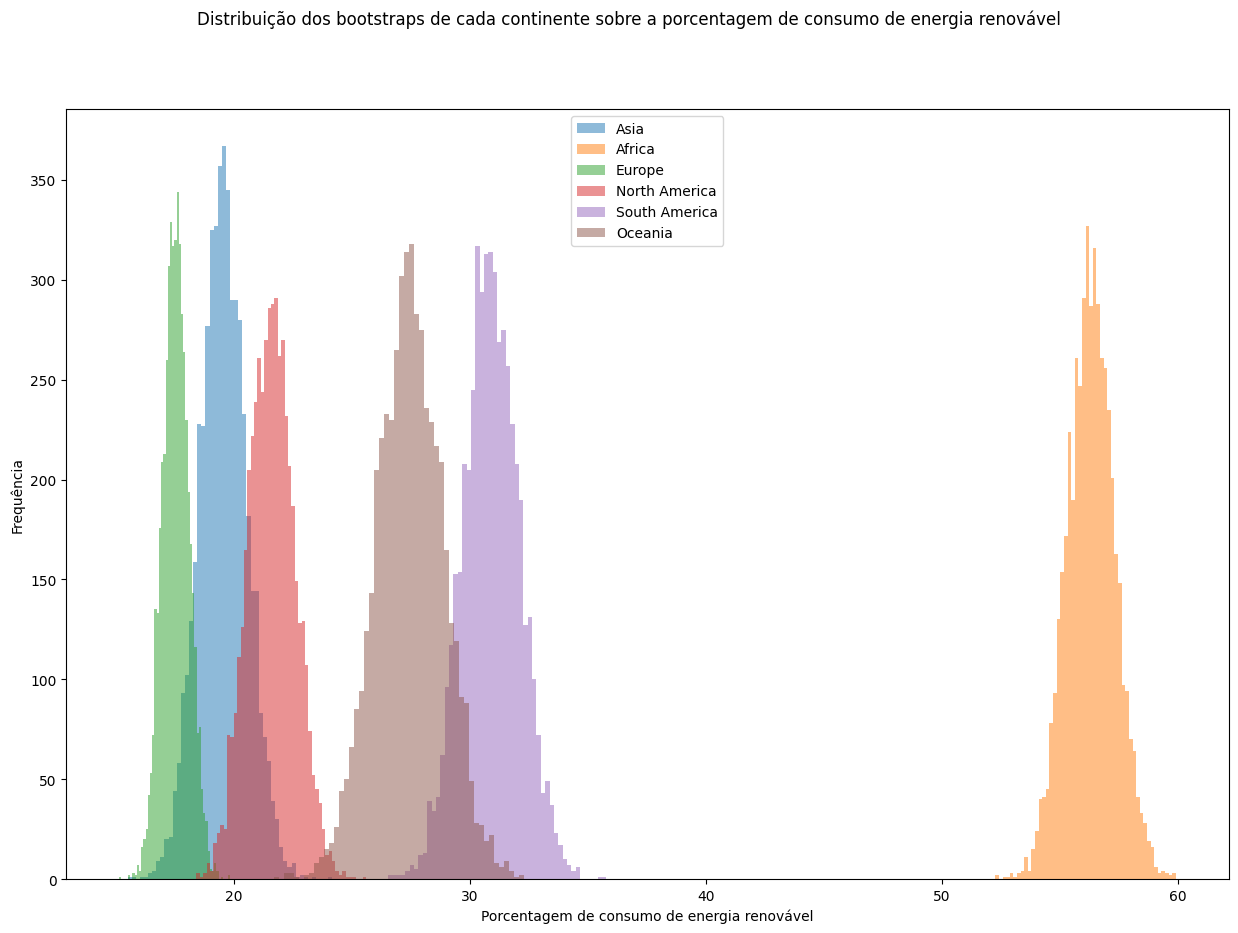

In [ ]:
fig, ax = plt.subplots(figsize=(15, 10))
labels = ['Asia', 'Africa', 'Europe', 'North America', 'South America', 'Oceania']
for i in range(len(filters)):
    ax.hist(boots[i], label=labels[i], bins=50, alpha=.5)

fig.suptitle('Distribuição dos bootstraps de cada continente sobre a porcentagem de consumo de energia renovável')
ax.set_xlabel('Porcentagem de consumo de energia renovável')
ax.set_ylabel('Frequência')

ax.legend()
plt.show()

A partir dos dados de porcentagem de participação de energia renovável na matriz energética do país, as classes (continentes) América do Sul e Oceania, assim como as classes América do Norte, Europa e Ásia são bastante semelhantes entre si. Restanto apenas a África com uma diferença significativa.

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import f1_score

X = global_renew[['Year', 'Renewable energy share']].copy()
y = global_renew['Continent']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Uso do get_dummies :)
# pd.get_dummies(crep, columns=['Continent'], drop_first=True)

# Z-Normalizando dados
col = 'Renewable energy share'
mean_train = X_train[col].mean()
std_train = X_train[col].std()

X_train[col] = (X_train[col] - mean_train) / std_train
X_test[col] = (X_test[col] - mean_train) / std_train

# One-hot encoding (TODO: Rever aqui, está meio estranho fazer para codificar o que(ano??))
# pd.get_dummies(X_train, columns=['Year'], drop_first=True)

In [ ]:
# Ajuste de hiperparâmetros

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5)

best_k = []

for train_index, test_index in skf.split(X_train, y_train):
    best_now = (0, 0)
    for k in [3, 5, 7, 9, 11, 13, 17, 19]:
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train.values[train_index], y_train.values[train_index])

        y_val = y_train.values[test_index]
        y_hat = model.predict(X_train.values[test_index])

        # Adicionar métricas aqui
        # print('Valor real: ', y_val)
        # print('Previsto: ', y_hat)

        # TODO: Rever métrica
        # Sei que tá comparando string aqui e isso é muito lento mas paciencia, logo logo resolvo isso
        # precision = (y_val == y_hat).mean()
        precision = f1_score(y_val, y_hat, average='macro')
        print(f'k: {k}, Precision: {precision}')
        if precision > best_now[0]:
            best_now = (precision, k)

    best_k.append(best_now)
    print()
    print()


i = 0
for k in best_k:
    print(f'Fold: {i} => Com k = {k[1]} e precision = {k[0]}')
    i += 1

k: 3, Precision: 0.2638799061590104
k: 5, Precision: 0.286131842391417
k: 7, Precision: 0.3100492470074416
k: 9, Precision: 0.30070202086012365
k: 11, Precision: 0.2784169383328811
k: 13, Precision: 0.279247723452376
k: 17, Precision: 0.2633881569926039
k: 19, Precision: 0.2602067264795369


k: 3, Precision: 0.2720342328985704
k: 5, Precision: 0.2667625261354265
k: 7, Precision: 0.259250387961006
k: 9, Precision: 0.2537185606581491
k: 11, Precision: 0.2586822554970905
k: 13, Precision: 0.26100111448088387
k: 17, Precision: 0.27327359969002085
k: 19, Precision: 0.2645612567458381


k: 3, Precision: 0.2616171575754351
k: 5, Precision: 0.2690596804969932
k: 7, Precision: 0.2740208685406435
k: 9, Precision: 0.29089263664226833
k: 11, Precision: 0.2874479707162563
k: 13, Precision: 0.2819255164459091
k: 17, Precision: 0.2706793222379769
k: 19, Precision: 0.2657387019772508


k: 3, Precision: 0.2639465782530291
k: 5, Precision: 0.27542733935740465
k: 7, Precision: 0.28551747210844364
k: 9, P

Abaixo mostramos como estão distribuídos os continentes sobre as características usadas (ano e porcentagem de energia renovável).

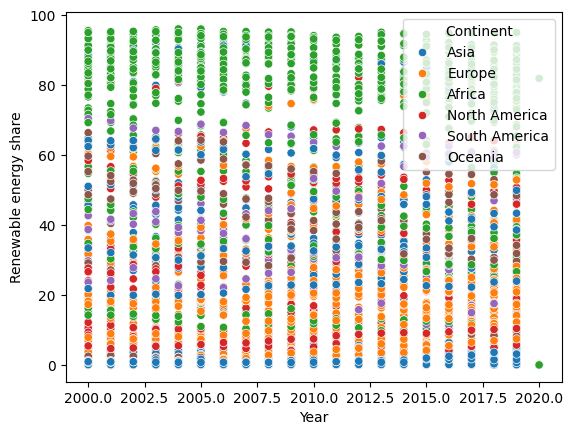

In [ ]:
# TODO: scatter plot: year vs renewable energy by country
sns.scatterplot(data=global_renew, x='Year', y='Renewable energy share', hue='Continent')
plt.show()

Agora, um avalição de qualidade do modelo para essa base, utilizando o hiperparâmetro k = 9 e k = 17.

In [ ]:
from sklearn.metrics import classification_report

model = KNeighborsClassifier(n_neighbors=9)
model.fit(X_train, y_train)

model17 = KNeighborsClassifier(n_neighbors=17)
model17.fit(X_train, y_train)


print('K = 9 \n', classification_report(y_test, model.predict(X_test)))
print('K = 17 \n', classification_report(y_test, model17.predict(X_test)))

K = 9 
                precision    recall  f1-score   support

       Africa       0.46      0.62      0.53       186
         Asia       0.30      0.41      0.35       122
       Europe       0.42      0.48      0.45       187
North America       0.15      0.05      0.08        97
      Oceania       0.10      0.04      0.06        50
South America       0.20      0.04      0.07        50

     accuracy                           0.38       692
    macro avg       0.27      0.27      0.25       692
 weighted avg       0.33      0.38      0.34       692

K = 17 
                precision    recall  f1-score   support

       Africa       0.46      0.61      0.52       186
         Asia       0.35      0.44      0.39       122
       Europe       0.40      0.53      0.46       187
North America       0.04      0.01      0.02        97
      Oceania       0.00      0.00      0.00        50
South America       0.00      0.00      0.00        50

     accuracy                           0.3

Matriz de confusão do modelo

Como foi esperado, a partir da análise do gráfico dos bootstraps por continente, o modelo teve uma qualidade razoável em diferenciar o continente África dos demais e para os demais continentes uma qualidade ruim.

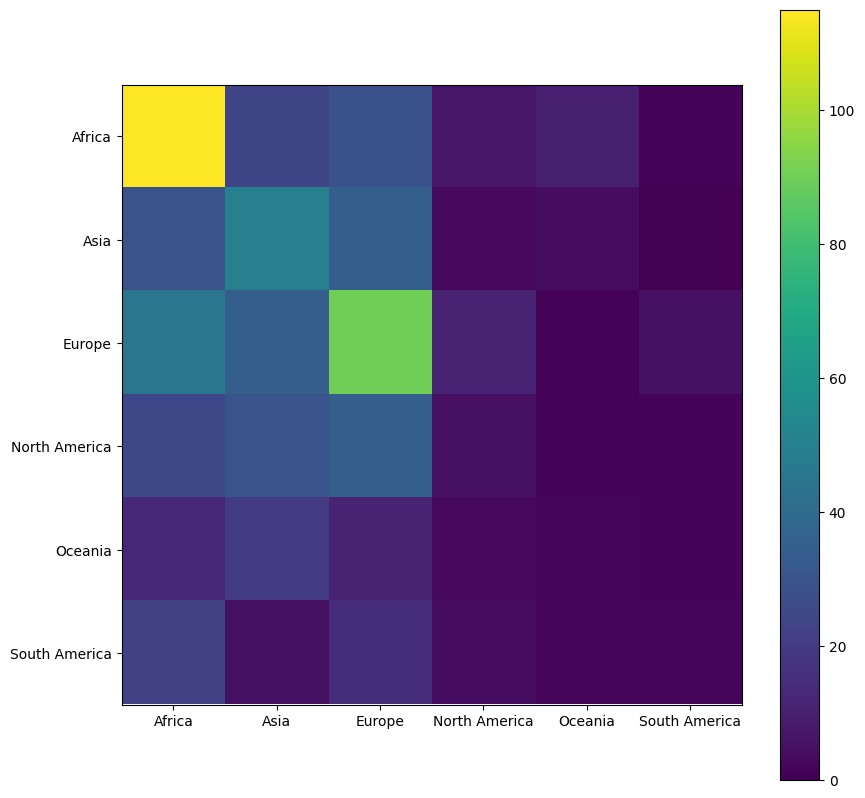

In [ ]:
# Matriz de confusão
from sklearn.metrics import confusion_matrix

plt.figure(figsize=(10, 10))
plt.imshow(confusion_matrix(y_test, model.predict(X_test)))
plt.xticks([0, 1, 2, 3, 4, 5], ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'])
plt.yticks([0, 1, 2, 3, 4, 5], ['Africa', 'Asia', 'Europe', 'North America', 'Oceania', 'South America'])
plt.colorbar()
plt.show()

## A partir da latitude e IDH, identificar se um país possui energia solar com mais de 1% de participação na sua matriz energética.

In [ ]:
df1 = pd.read_csv("https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/global-data-on-sustainable-energy.csv")
df1 = df1.dropna(subset=['Entity','Latitude'])
df1 = df1[['Entity','Latitude']].drop_duplicates(subset=['Entity'])
df1['Latitude'] = df1['Latitude'].abs()

df2 = pd.read_csv("https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/renewable_energy/14%20solar-share-energy.csv")
df2 = df2.dropna(subset=['Entity','Solar (% equivalent primary energy)'])
df2 = df2[['Entity','Year','Solar (% equivalent primary energy)']].query("Year >= 2010")

df3 = pd.read_csv('https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/human-development-index.csv')[['Entity','Year','Human Development Index']]


df = pd.merge(df1,df2,on='Entity')
df = pd.merge(df,df3,on=['Entity','Year']).drop('Year',axis=1)

In [ ]:
def bootstrap_mean(data,col,n):
  arr = np.zeros(n)
  d = data[col]
  s = len(d)
  for i in range(n):
    amostra = d.sample(s, replace=True)
    arr[i] = amostra.mean()

  return arr

In [ ]:
dfb = df[df['Latitude'] < 24]
dfa = df[df['Latitude'] >= 24]

mb = bootstrap_mean(dfb,'Solar (% equivalent primary energy)',5000)
ma = bootstrap_mean(dfa,'Solar (% equivalent primary energy)',5000)

# fazendo os gráficos para comparar as distribuições das médias obtidas via bootstrap
fig = go.Figure()
fig.add_trace(go.Histogram(x=mb,name='Entre dos trópicos'))
fig.add_trace(go.Histogram(x=ma,name='Fora dos trópicos'))

fig.update_layout(barmode='overlay',
                  title='Distribuição das médias da particação de energia solar na matriz energética dos países por latitude',
                  width=1080,
                  height=500,
                  yaxis_title="Número de ocorrências",
                  xaxis_title='Média de participação de energia solar na matriz energética do país por faixa de Latitude'
)

fig.show()

Poderíamos pensar que a latitude é o principal fator para um país ter uma maior participação de energia solar, devido à incidência de luz solar. Porém, conforme vemos no gráfico, o oposto ocorre.

In [ ]:
df3 = pd.read_csv('https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/human-development-index.csv')[['Entity','Year','Human Development Index']]

# juntando com a latitude
df = pd.merge(df1,df2,on='Entity')
df = pd.merge(df,df3,on=['Entity','Year']).drop('Year',axis=1)

def classeParticipacaoEnergia(x):
  if x<1:
    return 0 # baixa participação de energia solar na matriz
  return 1 # alta participação

def classeIDH(x):
  if x>0.8:
    return "Desenvolvido" # idh alto
  else:
    return "Não desenvolvidos" # idh médio

df['Classe'] = df['Solar (% equivalent primary energy)'].map(classeParticipacaoEnergia)
df['Status'] = df['Human Development Index'].map(classeIDH)

In [ ]:
# selecionando as colunas
x = df[['Latitude','Status']]
y = df['Classe']

# dividindo em treino/teste, z-normalizando

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=randint(1,100))

mean_train = X_train['Latitude'].mean()
std_train = X_train['Latitude'].std()

Z_train = X_train.copy()
Z_train['Latitude'] = Z_train['Latitude']-mean_train
Z_train['Latitude'] = Z_train['Latitude'] / std_train

Z_test = X_test.copy()
Z_test['Latitude'] = Z_test['Latitude']-mean_train
Z_test['Latitude'] = Z_test['Latitude']/std_train

D_train = pd.get_dummies(X_train)
D_test = pd.get_dummies(X_test)

In [ ]:
skf = StratifiedKFold(n_splits=5)

f = 1

for train_index,val_index in skf.split(D_train,y_train):
  print(f'Fold {f}:')
  for k in [1,3,5,7,9,11]:
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(D_train.values[train_index],y_train.values[train_index])

    y_val = y_train.values[val_index]
    y_hat = model.predict(D_train.values[val_index])


    precision = precision_score(y_val,y_hat)

    print(f"k = {k}, precisão = {precision}")
  print('\n')
  f+=1

Fold 1:
k = 1, precisão = 0.5142857142857142
k = 3, precisão = 0.5769230769230769
k = 5, precisão = 0.631578947368421
k = 7, precisão = 0.5909090909090909
k = 9, precisão = 0.8666666666666667
k = 11, precisão = 0.8181818181818182


Fold 2:
k = 1, precisão = 0.36666666666666664
k = 3, precisão = 0.5769230769230769
k = 5, precisão = 0.56
k = 7, precisão = 0.5769230769230769
k = 9, precisão = 0.5384615384615384
k = 11, precisão = 0.4827586206896552


Fold 3:
k = 1, precisão = 0.5806451612903226
k = 3, precisão = 0.6
k = 5, precisão = 0.6666666666666666
k = 7, precisão = 0.7407407407407407
k = 9, precisão = 0.7083333333333334
k = 11, precisão = 0.7083333333333334


Fold 4:
k = 1, precisão = 0.6111111111111112
k = 3, precisão = 0.6153846153846154
k = 5, precisão = 0.6086956521739131
k = 7, precisão = 0.6071428571428571
k = 9, precisão = 0.47058823529411764
k = 11, precisão = 0.5


Fold 5:
k = 1, precisão = 0.6818181818181818
k = 3, precisão = 0.68
k = 5, precisão = 0.7307692307692307
k = 7,

In [ ]:
px.scatter(data_frame=df,
           x='Latitude',
           y='Solar (% equivalent primary energy)',
           color='Status',
           labels={'Solar (% equivalent primary energy)': 'Participação de energia solar no total (%)',
            'Year':'Ano'},
           hover_name='Entity',
           width=1080
)

O gráfico acima mostra os dados utilizados no modelo apresentado, utilizando o Status (desenvolvimendo do país) e a latitude, classificar o país como um produtor de energia solar ou não.

Avaliação do modelo para k=7 e k=9

Lembrando que 0 = baixa participação de energia, 1 = alta participação

In [ ]:
model = KNeighborsClassifier(n_neighbors=7)
model.fit(D_train, y_train)
print('K = 7: \n', classification_report(y_test, model.predict(D_test)))

model = KNeighborsClassifier(n_neighbors=9)
model.fit(D_train, y_train)

print('K = 9: \n', classification_report(y_test, model.predict(D_test)))

K = 7: 
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       129
           1       0.84      0.61      0.71        44

    accuracy                           0.87       173
   macro avg       0.86      0.79      0.81       173
weighted avg       0.87      0.87      0.87       173

K = 9: 
               precision    recall  f1-score   support

           0       0.90      0.94      0.92       129
           1       0.79      0.68      0.73        44

    accuracy                           0.87       173
   macro avg       0.84      0.81      0.82       173
weighted avg       0.87      0.87      0.87       173



## A partir do ano e PIB per capita, classificar um país como tendo mais de 20% da sua matriz energética como energias renováveis ou não.

In [ ]:
df1 = (pd.read_csv('https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/global-data-on-sustainable-energy.csv')
      [['Entity','Year','gdp_per_capita']].
      query('Year >=2010')
)
df2 = pd.read_csv('https://raw.githubusercontent.com/souza-marcos/ICD_Projeto/main/data/renewable_energy/01%20renewable-share-energy.csv').query('Year>=2010').dropna(subset=['Entity','Year','Renewables (% equivalent primary energy)'])

df = pd.merge(df1,df2,on=['Entity','Year']).drop('Code',axis=1).dropna()

# classificando os dados em 0 e 1

def classificacaoRenovavel(n):
  if n<=20:
    return 0
  return 1

df['Classe energia renovavel'] = df['Renewables (% equivalent primary energy)'].map(classificacaoRenovavel)

In [ ]:
df_ricos = df.query('gdp_per_capita > 10000')
df_pobres = df.query('gdp_per_capita <=10000')

mp = bootstrap_mean(df_pobres,'Renewables (% equivalent primary energy)',5000)
mr = bootstrap_mean(df_ricos,'Renewables (% equivalent primary energy)',5000)

fig = go.Figure()
fig.add_trace(go.Histogram(x=mp,name='Países pobres'))
fig.add_trace(go.Histogram(x=mr,name='Países ricos'))

fig.update_layout(barmode='overlay',
                  title='Distribuição dos bootstraps da particação de energias renováveis na matriz energética dos países',
                  width=1080,
                  height=500,
                  yaxis_title="Número de ocorrências",
                  xaxis_title='Média de participação de energias renováveis na matriz energética do país por faixa de PIB per capita'
)

fig.update_traces(opacity=1)
fig.show()

De acordo com o gráfico, parece haver uma divisão forte entre as distribuições das médias de participação de energias renováveis entre países ricos e países pobres (definidos aqui com PIB per capita maior que 10000 U\$ ou menor/igual a 10000 U\$, respectivamente)

In [ ]:
# selecionando as colunas
x = df[['Year','gdp_per_capita']]
y = df['Classe energia renovavel']


In [ ]:
# criando e avaliando o modelo
from sklearn import tree

precision = 0.0

for f in range(1,6,1):
  X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,random_state=randint(1,100))

  mean_train = X_train['gdp_per_capita'].mean()
  std_train = X_train['gdp_per_capita'].std()

  Z_train = X_train.copy()
  Z_train['gdp_per_capita'] = Z_train['gdp_per_capita']-mean_train
  Z_train['gdp_per_capita'] = Z_train['gdp_per_capita'] / std_train

  Z_test = X_test.copy()
  Z_test['gdp_per_capita'] = Z_test['gdp_per_capita']-mean_train
  Z_test['gdp_per_capita'] = Z_test['gdp_per_capita']/std_train

  model = tree.DecisionTreeClassifier()
  model.fit(Z_train.values,y_train.values)

  y_hat = model.predict(Z_test)

  print(f'Fold {f}')
  print('Relatório da classificação: \n', classification_report(y_test.values, y_hat))
  precision += precision_score(y_test.values,y_hat)

  print('\n')
  f+=1

print(f"Precisão média: {precision/5}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names



Fold 1
Relatório da classificação: 
               precision    recall  f1-score   support

           0       0.84      0.79      0.82       121
           1       0.34      0.42      0.38        31

    accuracy                           0.72       152
   macro avg       0.59      0.61      0.60       152
weighted avg       0.74      0.72      0.73       152



Fold 2
Relatório da classificação: 
               precision    recall  f1-score   support

           0       0.84      0.77      0.80       124
           1       0.26      0.36      0.30        28

    accuracy                           0.69       152
   macro avg       0.55      0.56      0.55       152
weighted avg       0.73      0.69      0.71       152



Fold 3
Relatório da classificação: 
               precision    recall  f1-score   support

           0       0.84      0.77      0.81       123
           1       0.28      0.38      0.32        29

    accuracy                           0.70       152
   macro avg 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:458: UserWarning:

X has feature names, but DecisionTreeClassifier was fitted without feature names

